In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import pandas as pd

import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import fastparquet

import pickle
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from imblearn.ensemble import BalancedRandomForestClassifier

In [2]:
df1 = pd.read_csv(r"C:\Users\vicen\Desktop\Im_Stuff\General_files_tesis\Tesis\Clasificador-de-curvas-de-luz-utilizando-modelo-XGBoost-y-tecnicas-de-balance-de-datos-main\scripts\files\features_LCC.csv")
df2 = pd.read_csv(r"C:\Users\vicen\Desktop\Im_Stuff\General_files_tesis\Tesis\Clasificador-de-curvas-de-luz-utilizando-modelo-XGBoost-y-tecnicas-de-balance-de-datos-main\scripts\files\labels_LCC.csv")

In [3]:
def LabelEncoder(y_data):
    nclass = len(np.unique(y_data))
    LabelEncoder_dict = {
    4:{'SNIa':0,'SNII':1,'SNIbc':2,'SLSN':3},
    5:{'QSO':0,'AGN':1, 'YSO':2,'Blazar':3, 'CV/Nova':4},
    6:{'E':0,'RRL':1,'LPV':2,'Periodic-Other':3,'DSCT':4,'CEP':5},
    3:{'Transient':0, 'Stochastic':1, 'Periodic':2},
    15:{'SNIa':0,'SNII':1,'SNIbc':2,'SLSN':3,'QSO':4,'AGN':5, 'YSO':6,'Blazar':7, 'CV/Nova':8,'E':9,'RRL':10,'LPV':11,'Periodic-Other':12,'DSCT':13,'CEP':14}}
    y_data_encoded = y_data.apply(lambda x: LabelEncoder_dict[nclass][x])
    return y_data_encoded

Labels_dict={'Hierarchical':['Transient','Stochastic', 'Periodic'],
            'Periodic':['E','RRL','LPV','P-Other','DSCT','CEP'],
            'Stochastic':['QSO','AGN', 'YSO','Blazar', 'CV/Nova'],
            'Transient':['SNIa','SNII','SNIbc','SLSN'],
            'Complete':['SNIa','SNII','SNIbc','SLSN','QSO','AGN', 'YSO','Blazar', 'CV/Nova','E','RRL','LPV','Periodic-Other','DSCT','CEP']
           }

In [4]:
def CBA(preds, dtrain):
    y_pred = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)
    y_true = np.array(dtrain.get_label(), dtype=int, ndmin=1)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    n_sum=0
    for i in range(len(cnf_matrix)):
        num = cnf_matrix[i,i]
        den = max(sum(cnf_matrix[i,:]),sum(cnf_matrix[:,i]))
        n_sum+=num/den
    return 'CBA', -n_sum/len(cnf_matrix)


def min_recall(preds, dtrain):
    for i in range(len(preds)):
        preds[i] = np.exp(preds[i])/np.sum(np.exp(preds[i]))
    y_pred = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)
    y_true = np.array(dtrain.get_label(), dtype=int, ndmin=1)
    score = np.min(recall_score(y_true, y_pred, average='macro'))
    return 'min_recall', -score

from hmeasure import h_score


def hmeasurescore(preds, dtrain):
    for i in range(len(preds)):
        preds[i] = np.exp(preds[i])/np.sum(np.exp(preds[i]))
    y_pred = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)
    y_true = np.array(dtrain.get_label(), dtype=int, ndmin=1)
    counts = np.bincount(y_true)
    min_class = np.argmin(counts)
    y_pred2 = np.array(y_pred ==min_class, dtype=np.float64)
    y_true2 = np.array(y_true ==min_class, dtype=np.float64)
    score = h_score(y_true2, y_pred2)
    return 'hscore', -score

def hmeasures(y_pred, y_true):
    counts = np.bincount(y_true)
    min_class = np.argmin(counts)
    y_pred2 = np.array(y_pred ==min_class, dtype=np.float64)
    y_true2 = np.array(y_true ==min_class, dtype=np.float64)
    score = h_score(y_true2, y_pred2)
    return score

def recall_mod_v1(y_true,y_pred,weights):
    weights=weights/np.sum(weights)
    return np.dot(weights.sort_index(),recall_score(y_true, y_pred, average=None))
    

In [5]:
X = df1.drop(['oid'],axis=1).copy()
y_o = df2['class_original'].copy()
y_h = df2['class_hierarchical'].copy()
item_counts = y_h.value_counts(normalize=False)
#print(item_counts)
item_counts = y_o.value_counts(normalize=False)
#print(item_counts)


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from hyperopt import STATUS_OK,Trials,fmin,hp,tpe
from hyperopt.early_stop import no_progress_loss
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.early_stop import no_progress_loss
SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score
import pickle


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model: BRF Periodic
Precision: Mean = 0.558480053137356; Std = 0.0023046114713508817
Recall: Mean = 0.8231008904966644; Std = 0.006183957777206582
F1-score: Mean = 0.5849049403654238; Std = 0.003942959379867464
Min recall: Mean = 0.714885931940756; Std = 0.008581392553057428
Recall Mod: Mean = 0.7906500524479217; Std = 0.014497797916606036


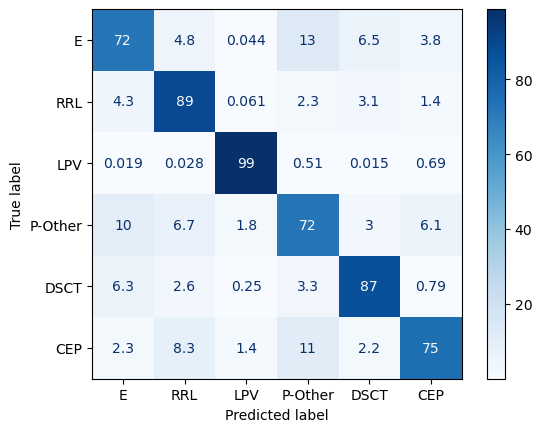

In [11]:
subclass= 'Periodic'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)

n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=np.zeros(n_splits)
recalls=np.zeros(n_splits)
f1s=np.zeros(n_splits)
matrixes=np.zeros((n_splits,n_classes,n_classes))
minrecalls=np.zeros(n_splits)
modrecalls=np.zeros(n_splits)
preds_dict={}
tests_dict={}
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    
    X_train[X_train > 1e32] = 0
    
    X_train=X_train.fillna(-999)
    X_test=X_test.fillna(-999)
    
    

    rf_model = BalancedRandomForestClassifier(
                         n_estimators=500,
                         max_features=13,#'auto',
                         max_depth=None,
                         n_jobs=-1,
                         bootstrap=True,
                         criterion='gini',
                         min_samples_split=10,
                         min_samples_leaf=10)
    rf_model.fit(X_train,y_train)
    preds_test = rf_model.predict(X_test)
    
    classreport=classification_report(y_test,preds_test,output_dict=True)
    precisions[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['precision']
    recalls[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['recall']
    f1s[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['f1-score']
    matrixes[i]=confusion_matrix(y_test,preds_test,normalize='true')*100
    minrecalls[i]=np.min(recall_score(y_test, preds_test, average=None))
    modrecalls[i]=recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True)))
    i=i+1
    preds_dict[i]=preds_test
    tests_dict[i]=y_test
file_name = 'ResultadosFinales/Periodic_BRF_Preds.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Periodic_BRF_Tests.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)
    
print('Model: BRF Periodic')
print('Precision: Mean = ' + str(np.mean(precisions)) + '; Std = '+ str(np.std(precisions)))
print('Recall: Mean = ' + str(np.mean(recalls)) + '; Std = '+ str(np.std(recalls)))
print('F1-score: Mean = ' + str(np.mean(f1s)) + '; Std = '+ str(np.std(f1s)))
print('Min recall: Mean = ' + str(np.mean(minrecalls)) + '; Std = '+ str(np.std(minrecalls)))
print('Recall Mod: Mean = ' + str(np.mean(modrecalls)) + '; Std = '+ str(np.std(modrecalls)))


disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0), display_labels=Labels_dict[subclass])
disp.plot(cmap='Blues')
plt.show()

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model: BRF Stochastic
Precision: Mean = 0.7436270534518521; Std = 0.006478524970030296
Recall: Mean = 0.8592184680639401; Std = 0.004114833696464603
F1-score: Mean = 0.7882536966721523; Std = 0.004468644637523956
Min recall: Mean = 0.6607655502392344; Std = 0.021312016699827838
Recall Mod: Mean = 0.8641577991548711; Std = 0.0067058703756609495


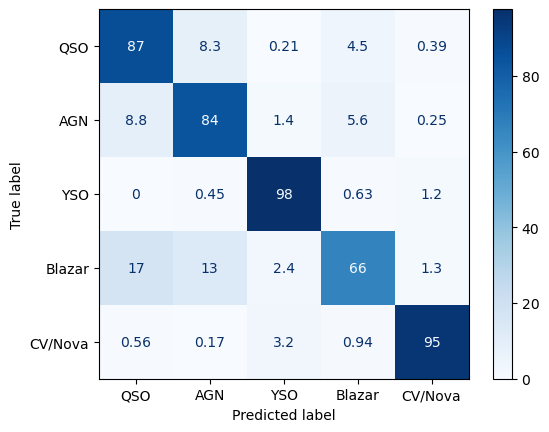

In [7]:
subclass= 'Stochastic'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)

n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=np.zeros(n_splits)
recalls=np.zeros(n_splits)
f1s=np.zeros(n_splits)
matrixes=np.zeros((n_splits,n_classes,n_classes))
minrecalls=np.zeros(n_splits)
modrecalls=np.zeros(n_splits)
preds_dict={}
tests_dict={}
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    
    X_train[X_train > 1e32] = 0
    
    X_train=X_train.fillna(-999)
    X_test=X_test.fillna(-999)
    
    

    rf_model = BalancedRandomForestClassifier(
                         n_estimators=500,
                         max_features=13,#'auto',
                         max_depth=None,
                         n_jobs=-1,
                         bootstrap=True,
                         criterion='gini',
                         min_samples_split=10,
                         min_samples_leaf=10)
    rf_model.fit(X_train,y_train)
    preds_test = rf_model.predict(X_test)
    
    classreport=classification_report(y_test,preds_test,output_dict=True)
    precisions[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['precision']
    recalls[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['recall']
    f1s[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['f1-score']
    matrixes[i]=confusion_matrix(y_test,preds_test,normalize='true')*100
    minrecalls[i]=np.min(recall_score(y_test, preds_test, average=None))
    modrecalls[i]=recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True)))
    i=i+1
    preds_dict[i]=preds_test
    tests_dict[i]=y_test
file_name = 'ResultadosFinales/Stochastic_BRF_Preds.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Stochastic_BRF_Tests.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)
    
print('Model: BRF Stochastic')
print('Precision: Mean = ' + str(np.mean(precisions)) + '; Std = '+ str(np.std(precisions)))
print('Recall: Mean = ' + str(np.mean(recalls)) + '; Std = '+ str(np.std(recalls)))
print('F1-score: Mean = ' + str(np.mean(f1s)) + '; Std = '+ str(np.std(f1s)))
print('Min recall: Mean = ' + str(np.mean(minrecalls)) + '; Std = '+ str(np.std(minrecalls)))
print('Recall Mod: Mean = ' + str(np.mean(modrecalls)) + '; Std = '+ str(np.std(modrecalls)))


disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0), display_labels=Labels_dict[subclass])
disp.plot(cmap='Blues')
plt.show()

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model: BRF Transient
Precision: Mean = 0.4956455780523793; Std = 0.01930439986183097
Recall: Mean = 0.6538301503298052; Std = 0.03475524452088797
F1-score: Mean = 0.49613480316420927; Std = 0.014563890052992566
Min recall: Mean = 0.5116869918699187; Std = 0.048402690976367416
Recall Mod: Mean = 0.7264702881654636; Std = 0.0837946033489571


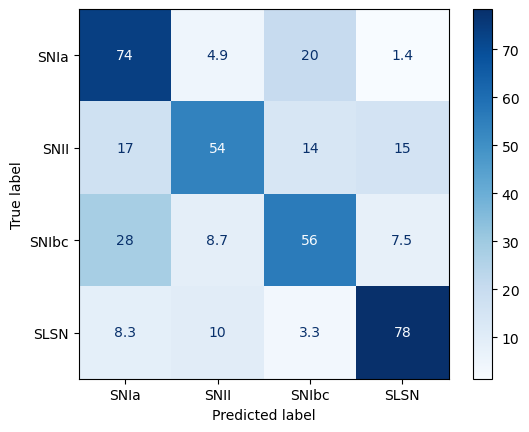

In [10]:
subclass= 'Transient'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)

n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=np.zeros(n_splits)
recalls=np.zeros(n_splits)
f1s=np.zeros(n_splits)
matrixes=np.zeros((n_splits,n_classes,n_classes))
minrecalls=np.zeros(n_splits)
modrecalls=np.zeros(n_splits)
preds_dict={}
tests_dict={}
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    
    X_train[X_train > 1e32] = 0
    
    X_train=X_train.fillna(-999)
    X_test=X_test.fillna(-999)
    
    

    rf_model = BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
    rf_model.fit(X_train,y_train)
    preds_test = rf_model.predict(X_test)
    
    classreport=classification_report(y_test,preds_test,output_dict=True)
    precisions[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['precision']
    recalls[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['recall']
    f1s[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['f1-score']
    matrixes[i]=confusion_matrix(y_test,preds_test,normalize='true')*100
    minrecalls[i]=np.min(recall_score(y_test, preds_test, average=None))
    modrecalls[i]=recall_mod_v1(y_test,preds_test,1/y_train.value_counts(normalize=True))
    i=i+1
    preds_dict[i]=preds_test
    tests_dict[i]=y_test
file_name = 'ResultadosFinales/Transient_BRF_Preds.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Transient_BRF_Tests.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)
    
print('Model: BRF Transient')
print('Precision: Mean = ' + str(np.mean(precisions)) + '; Std = '+ str(np.std(precisions)))
print('Recall: Mean = ' + str(np.mean(recalls)) + '; Std = '+ str(np.std(recalls)))
print('F1-score: Mean = ' + str(np.mean(f1s)) + '; Std = '+ str(np.std(f1s)))
print('Min recall: Mean = ' + str(np.mean(minrecalls)) + '; Std = '+ str(np.std(minrecalls)))
print('Recall Mod: Mean = ' + str(np.mean(modrecalls)) + '; Std = '+ str(np.std(modrecalls)))


disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0), display_labels=Labels_dict[subclass])
disp.plot(cmap='Blues')
plt.show()

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model: BRF Transient
Precision: Mean = 0.9558003162582274; Std = 0.0065568365965147524
Recall: Mean = 0.9866934083192621; Std = 0.0006247467034881248
F1-score: Mean = 0.9701141129473833; Std = 0.0037793219457880464
Min recall: Mean = 0.9669163401705463; Std = 0.0016638837061951205
Recall Mod: Mean = 0.9937812578244646; Std = 0.00037903976562654026


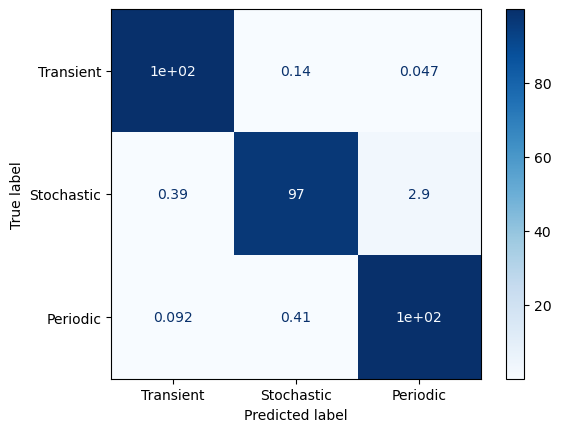

In [18]:
X_sc = X.copy()
y_sc = y_h
y_sc_enc=LabelEncoder(y_sc)

n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=np.zeros(n_splits)
recalls=np.zeros(n_splits)
f1s=np.zeros(n_splits)
matrixes=np.zeros((n_splits,n_classes,n_classes))
minrecalls=np.zeros(n_splits)
modrecalls=np.zeros(n_splits)
preds_dict={}
tests_dict={}
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    
    X_train[X_train > 1e32] = 0
    
    X_train=X_train.fillna(-999)
    X_test=X_test.fillna(-999)
    


    rf_model = BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
    rf_model.fit(X_train,y_train)
    preds_test = rf_model.predict(X_test)
    
    classreport=classification_report(y_test,preds_test,output_dict=True)
    precisions[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['precision']
    recalls[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['recall']
    f1s[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['f1-score']
    matrixes[i]=confusion_matrix(y_test,preds_test,normalize='true')*100
    minrecalls[i]=np.min(recall_score(y_test, preds_test, average=None))
    modrecalls[i]=recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True)))
    i=i+1
    preds_dict[i]=preds_test
    tests_dict[i]=y_test
file_name = 'ResultadosFinales/Hierarch_BRF_Preds.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Hierarch_BRF_Tests.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)
    
print('Model: BRF Transient')
print('Precision: Mean = ' + str(np.mean(precisions)) + '; Std = '+ str(np.std(precisions)))
print('Recall: Mean = ' + str(np.mean(recalls)) + '; Std = '+ str(np.std(recalls)))
print('F1-score: Mean = ' + str(np.mean(f1s)) + '; Std = '+ str(np.std(f1s)))
print('Min recall: Mean = ' + str(np.mean(minrecalls)) + '; Std = '+ str(np.std(minrecalls)))
print('Recall Mod: Mean = ' + str(np.mean(modrecalls)) + '; Std = '+ str(np.std(modrecalls)))


disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0), display_labels=Labels_dict['Hierarchical'])
disp.plot(cmap='Blues')
plt.show()

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model: BRF Complete
Precision: Mean = 0.5822247866279037; Std = 0.005351611492578344
Recall: Mean = 0.7630266370824287; Std = 0.008864071535570858
F1-score: Mean = 0.6066149630402926; Std = 0.005751217533622523
Min recall: Mean = 0.48195475433015195; Std = 0.04637637125536715
Recall Mod: Mean = 0.8027356551426867; Std = 0.016925121840247498


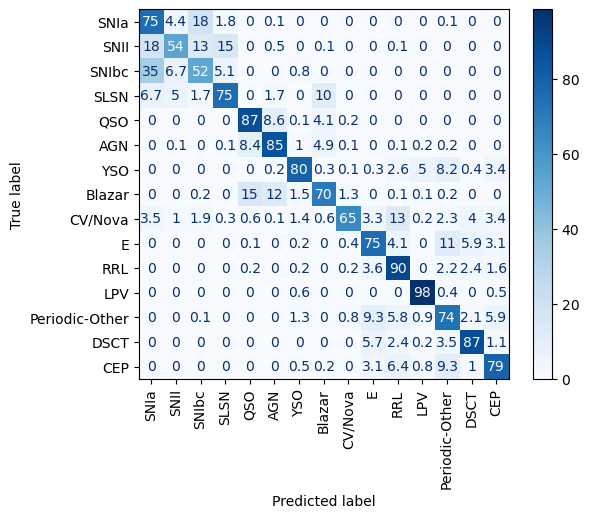

In [37]:
n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=np.zeros(n_splits)
recalls=np.zeros(n_splits)
f1s=np.zeros(n_splits)
matrixes=np.zeros((n_splits,n_classes,n_classes))
minrecalls=np.zeros(n_splits)
modrecalls=np.zeros(n_splits)
preds_dict={}
tests_dict={}
for train_index, test_index in sss.split(X, LabelEncoder(y_o)):
    print('iteration '+str(i))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_o_train, y_o_test = LabelEncoder(y_o).iloc[train_index], LabelEncoder(y_o).iloc[test_index]
    y_h_train, y_h_test = LabelEncoder(y_h).iloc[train_index], LabelEncoder(y_h).iloc[test_index]
    
    X_train[X_train > 1e32] = 0
    
    X_train=X_train.fillna(-999)
    X_test=X_test.fillna(-999)
    
    

    rf_model_H = BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
    rf_model_H.fit(X_train,y_h_train)
    preds_test_H = rf_model_H.predict_proba(X_test)
    
    ######
    subclass=2
    X_sc = X_train.loc[y_h_train==subclass, :]
    X_sc_test=  X_test.loc[y_h_test==subclass, :]
    y_p_train = y_o_train.loc[y_h_train==subclass]
    y_p_test = y_o_test.loc[y_h_test==subclass]
    
    rf_model_P = BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
    rf_model_P.fit(X_sc,y_p_train)
    preds_test_P = rf_model_P.predict_proba(X_test)
    
    
    ######
    subclass=1
    X_sc = X_train.loc[y_h_train==subclass, :]
    X_sc_test=  X_test.loc[y_h_test==subclass, :]
    y_s_train = y_o_train.loc[y_h_train==subclass]
    y_s_test = y_o_test.loc[y_h_test==subclass]
    
    rf_model_S = BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
    rf_model_S.fit(X_sc,y_s_train)
    preds_test_S = rf_model_S.predict_proba(X_test)
    
    ######
    subclass=0
    X_sc = X_train.loc[y_h_train==subclass, :]
    X_sc_test=  X_test.loc[y_h_test==subclass, :]
    y_t_train = y_o_train.loc[y_h_train==subclass]
    y_t_test = y_o_test.loc[y_h_test==subclass]
    
    rf_model_T = BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
    rf_model_T.fit(X_sc,y_t_train)
    preds_test_T = rf_model_T.predict_proba(X_test)
    #####
    periodic_probs = preds_test_P*preds_test_H[:,2].reshape([-1, 1])
    stochastic_probs = preds_test_S*preds_test_H[:,1].reshape([-1, 1])

    transient_probs = preds_test_T*preds_test_H[:,0].reshape([-1, 1])

    final_probs = np.concatenate(
            [transient_probs,stochastic_probs, periodic_probs ],
            axis=1
            )
    preds_labels_final = np.array(np.argmax(np.array(final_probs),axis=1), ndmin=1)
    y_test=y_o_test
    preds_test=preds_labels_final
    classreport=classification_report(y_test,preds_test,output_dict=True)
    precisions[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['precision']
    recalls[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['recall']
    f1s[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['f1-score']
    matrixes[i]=confusion_matrix(y_test,preds_test,normalize='true')*100
    minrecalls[i]=np.min(recall_score(y_test, preds_test, average=None))
    modrecalls[i]=recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True)))
    i=i+1
    preds_dict[i]=preds_test
    tests_dict[i]=y_test
file_name = 'ResultadosFinales/Complete_BRF_Preds.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Complete_BRF_Tests.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)
    
print('Model: BRF Complete')
print('Precision: Mean = ' + str(np.mean(precisions)) + '; Std = '+ str(np.std(precisions)))
print('Recall: Mean = ' + str(np.mean(recalls)) + '; Std = '+ str(np.std(recalls)))
print('F1-score: Mean = ' + str(np.mean(f1s)) + '; Std = '+ str(np.std(f1s)))
print('Min recall: Mean = ' + str(np.mean(minrecalls)) + '; Std = '+ str(np.std(minrecalls)))
print('Recall Mod: Mean = ' + str(np.mean(modrecalls)) + '; Std = '+ str(np.std(modrecalls)))


cm_rounded = np.round(np.mean(matrixes,axis=0), 1)
disp=ConfusionMatrixDisplay(cm_rounded, display_labels=Labels_dict['Complete'])
fig, ax = plt.subplots()
cbar = fig.colorbar(cax, format='%.1e')
cbar.remove()
disp.plot(cmap='Blues',ax=ax)
for label in ax.get_xticklabels():
    label.set_rotation(90)
plt.show()

In [7]:
Xnew = pd.read_pickle('NewdataFeatures.pkl')
for element in ['W1','W2','W3','W4','W1-W2','W2-W3','r-W3','r-W2','g-W3','g-W2']:
    non_floats = Xnew[~Xnew[element].apply(lambda x: isinstance(x, (int, float)))]
    Xnew.loc[non_floats.index, element] = np.nan
    Xnew[element] = Xnew[element].astype(float)
    
Xnew[Xnew > 1e32] =0

y_new = pd.read_pickle('labels_filtered.pkl')
y_new_h= y_new.replace({'E':'Periodic','RRL':'Periodic','LPV':'Periodic','Periodic-Other':'Periodic','DSCT':'Periodic','CEP':'Periodic',
                        'QSO':'Stochastic','AGN':'Stochastic', 'YSO':'Stochastic','Blazar':'Stochastic', 'CV/Nova':'Stochastic'
                        ,'SNIa':'Transient','SNII':'Transient','SNIbc':'Transient','SLSN' :'Transient'})

In [8]:

Xnew = Xnew.loc[~Xnew.index.duplicated(keep='first')]
common_index = Xnew.index.intersection(y_new.index)
Xnew = Xnew.reindex(common_index)
y_new = y_new.reindex(common_index)
y_new_h= y_new.replace({'E':'Periodic','RRL':'Periodic','LPV':'Periodic','Periodic-Other':'Periodic','DSCT':'Periodic','CEP':'Periodic',
                        'QSO':'Stochastic','AGN':'Stochastic', 'YSO':'Stochastic','Blazar':'Stochastic', 'CV/Nova':'Stochastic'
                        ,'SNIa':'Transient','SNII':'Transient','SNIbc':'Transient','SLSN' :'Transient'})
X_train, X_test = X, Xnew[X.columns]
y_o_train, y_o_test = LabelEncoder(y_o), LabelEncoder(y_new)
y_h_train, y_h_test = LabelEncoder(y_h), LabelEncoder(y_new_h)

In [9]:
len(X_test)

99109

H
P
S
T


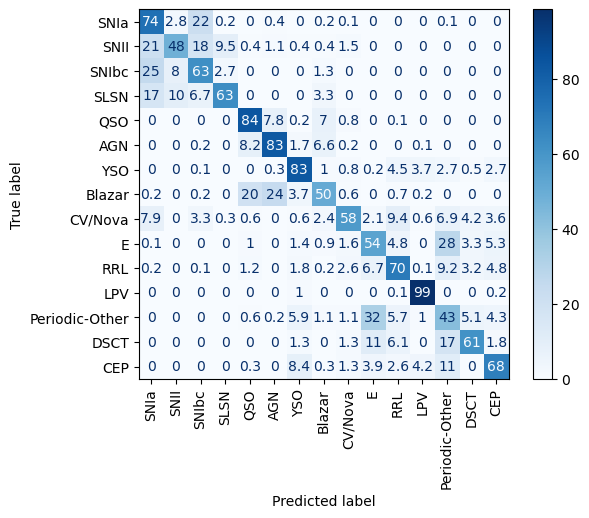

In [10]:

n_classes=15


X_train, X_test = X, Xnew[X.columns]
y_o_train, y_o_test = LabelEncoder(y_o), LabelEncoder(y_new)
y_h_train, y_h_test = LabelEncoder(y_h), LabelEncoder(y_new_h)

X_train[X_train > 1e32] = 0

X_train=X_train.fillna(-999)
X_test=X_test.fillna(-999)

print('H')

rf_model_H = BalancedRandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        max_depth=None,
        n_jobs=-1,
        bootstrap=True,
        criterion='entropy',
        min_samples_split=2,
        min_samples_leaf=1)
rf_model_H.fit(X_train,y_h_train)
preds_test_H = rf_model_H.predict_proba(X_test)

######

print('P')

subclass=2
X_sc = X_train.loc[y_h_train==subclass, :]
X_sc_test=  X_test
y_p_train = y_o_train.loc[y_h_train==subclass]
y_p_test = y_o_test

rf_model_P = BalancedRandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        max_depth=None,
        n_jobs=-1,
        bootstrap=True,
        criterion='entropy',
        min_samples_split=2,
        min_samples_leaf=1)
rf_model_P.fit(X_sc,y_p_train)
preds_test_P = rf_model_P.predict_proba(X_test)

print('S')
######
subclass=1
X_sc = X_train.loc[y_h_train==subclass, :]
X_sc_test=  X_test
y_s_train = y_o_train.loc[y_h_train==subclass]
y_s_test = y_o_test

rf_model_S = BalancedRandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        max_depth=None,
        n_jobs=-1,
        bootstrap=True,
        criterion='entropy',
        min_samples_split=2,
        min_samples_leaf=1)
rf_model_S.fit(X_sc,y_s_train)
preds_test_S = rf_model_S.predict_proba(X_test)

######
print('T')
subclass=0
X_sc = X_train.loc[y_h_train==subclass, :]
X_sc_test=  X_test
y_t_train = y_o_train.loc[y_h_train==subclass]
y_t_test = y_o_test

rf_model_T = BalancedRandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        max_depth=None,
        n_jobs=-1,
        bootstrap=True,
        criterion='entropy',
        min_samples_split=2,
        min_samples_leaf=1)
rf_model_T.fit(X_sc,y_t_train)
preds_test_T = rf_model_T.predict_proba(X_test)
#####
periodic_probs = preds_test_P*preds_test_H[:,2].reshape([-1, 1])
stochastic_probs = preds_test_S*preds_test_H[:,1].reshape([-1, 1])

transient_probs = preds_test_T*preds_test_H[:,0].reshape([-1, 1])

final_probs = np.concatenate(
        [transient_probs,stochastic_probs, periodic_probs ],
        axis=1
        )
preds_labels_final = np.array(np.argmax(np.array(final_probs),axis=1), ndmin=1)
y_test=y_o_test
preds_test=preds_labels_final


matrixes=confusion_matrix(y_test,preds_test,normalize='true')*100

    


cm_rounded = np.round(matrixes, 1)
disp=ConfusionMatrixDisplay(cm_rounded, display_labels=Labels_dict['Complete'])
fig, ax = plt.subplots()
disp.plot(cmap='Blues',ax=ax)
for label in ax.get_xticklabels():
    label.set_rotation(90)
plt.show()

In [31]:
print(recall_mod_v1(y_test,preds_test,1/LabelEncoder(y_o).value_counts()))
print(np.min(recall_score(y_test, preds_test, average=None)))
print(classification_report(y_test,preds_test,output_dict=False))

0.6246860558032127
0.46730462519936206
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1395
           1       0.70      0.53      0.60       274
           2       0.11      0.61      0.19        75
           3       0.31      0.63      0.42        30
           4       0.97      0.84      0.90     26321
           5       0.48      0.83      0.60      2469
           6       0.75      0.83      0.79      3184
           7       0.11      0.52      0.18       537
           8       0.17      0.55      0.26       331
           9       0.93      0.52      0.67     21916
          10       0.84      0.70      0.76      9196
          11       1.00      0.99      0.99     31989
          12       0.04      0.47      0.07       627
          13       0.21      0.58      0.31       457
          14       0.10      0.68      0.17       308

    accuracy                           0.79     99109
   macro avg       0.51      0.67      0.

[2 2 2 ... 2 3 2]


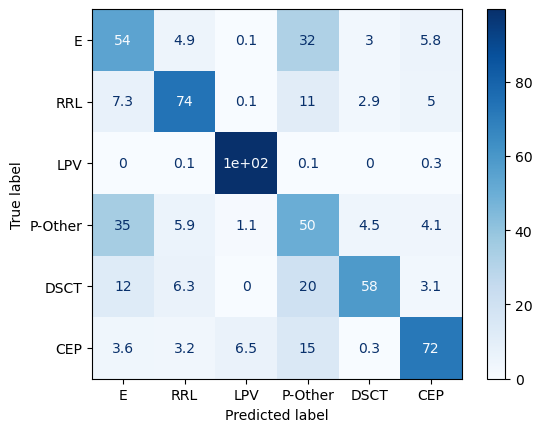

              precision    recall  f1-score   support

           0       0.93      0.54      0.68     21916
           1       0.85      0.74      0.79      9196
           2       1.00      0.99      1.00     31989
           3       0.04      0.50      0.07       627
           4       0.22      0.58      0.32       457
           5       0.11      0.72      0.19       308

    accuracy                           0.79     64493
   macro avg       0.52      0.68      0.51     64493
weighted avg       0.93      0.79      0.84     64493

mod recall:0.6301446790414974
min recall:0.49760765550239233


In [43]:
Xnewp=Xnew[y_new_h=='Periodic'][X.columns].fillna(-999)
preds_p = rf_model_P.predict_proba(Xnewp)

for k in range(len(preds_p)):
        preds_p[k] = np.exp(preds_p[k])/np.sum(np.exp(preds_p[k]))
preds_labels_p = np.array(np.argmax(np.array(preds_p),axis=1), ndmin=1)
test=LabelEncoder(y_new[y_new_h=='Periodic'])
cm_rounded = np.round(confusion_matrix(test,preds_labels_p,normalize='true')*100, 1)
disp=ConfusionMatrixDisplay(cm_rounded, display_labels=Labels_dict['Periodic'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(test,preds_labels_p))
print('mod recall:'+ str(recall_mod_v1(test,preds_labels_p,(1/LabelEncoder(y_o[y_h=='Periodic']).value_counts(normalize=True)).sort_index())))
print('min recall:'+ str(np.min(recall_score(test,preds_labels_p, average=None))))

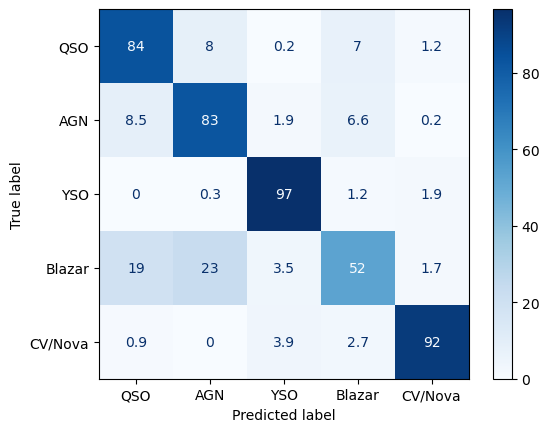

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     26321
           1       0.48      0.83      0.61      2469
           2       0.96      0.97      0.96      3184
           3       0.12      0.53      0.20       537
           4       0.43      0.92      0.59       331

    accuracy                           0.84     32842
   macro avg       0.60      0.82      0.65     32842
weighted avg       0.93      0.84      0.87     32842

mod recall:0.8104777593125996
min recall:0.5251396648044693


In [44]:
Xnewp=Xnew[y_new_h=='Stochastic'][X.columns].fillna(-999)
preds_p = rf_model_S.predict_proba(Xnewp)

for k in range(len(preds_p)):
        preds_p[k] = np.exp(preds_p[k])/np.sum(np.exp(preds_p[k]))
preds_labels_p = np.array(np.argmax(np.array(preds_p),axis=1), ndmin=1)
test=LabelEncoder(y_new[y_new_h=='Stochastic'])
cm_rounded = np.round(confusion_matrix(test,preds_labels_p,normalize='true')*100, 1)
disp=ConfusionMatrixDisplay(cm_rounded, display_labels=Labels_dict['Stochastic'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(test,preds_labels_p))
print('mod recall:'+ str(recall_mod_v1(test,preds_labels_p,(1/LabelEncoder(y_o[y_h=='Stochastic']).value_counts(normalize=True)).sort_index())))
print('min recall:'+ str(np.min(recall_score(test,preds_labels_p, average=None))))

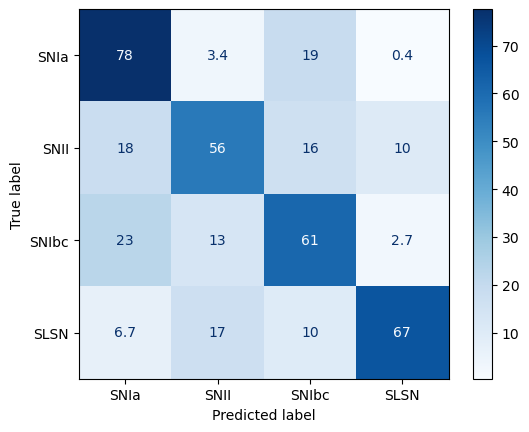

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1395
           1       0.71      0.56      0.63       274
           2       0.13      0.61      0.21        75
           3       0.36      0.67      0.47        30

    accuracy                           0.73      1774
   macro avg       0.53      0.65      0.54      1774
weighted avg       0.86      0.73      0.78      1774

mod recall:0.6522061129676062
min recall:0.5583941605839416


In [46]:
Xnewp=Xnew[y_new_h=='Transient'][X.columns].fillna(-999)
preds_p = rf_model_T.predict_proba(Xnewp)

for k in range(len(preds_p)):
        preds_p[k] = np.exp(preds_p[k])/np.sum(np.exp(preds_p[k]))
preds_labels_p = np.array(np.argmax(np.array(preds_p),axis=1), ndmin=1)
test=LabelEncoder(y_new[y_new_h=='Transient'])
cm_rounded = np.round(confusion_matrix(test,preds_labels_p,normalize='true')*100, 1)
disp=ConfusionMatrixDisplay(cm_rounded, display_labels=Labels_dict['Transient'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(test,preds_labels_p))
print('mod recall:'+ str(recall_mod_v1(test,preds_labels_p,(1/LabelEncoder(y_o[y_h=='Transient']).value_counts(normalize=True)).sort_index())))
print('min recall:'+ str(np.min(recall_score(test,preds_labels_p, average=None))))

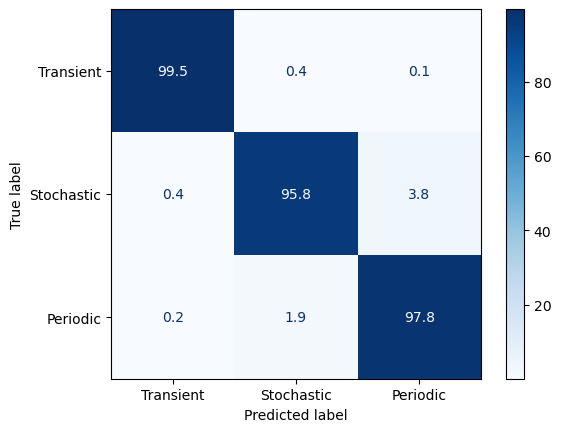

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1774
           1       0.96      0.96      0.96     32842
           2       0.98      0.98      0.98     64493

    accuracy                           0.97     99109
   macro avg       0.93      0.98      0.95     99109
weighted avg       0.97      0.97      0.97     99109

mod recall:0.9934196206246789
min recall:0.9575847999512819


In [11]:
Xnewp=Xnew[X.columns].fillna(-999)
preds_p = rf_model_H.predict_proba(Xnewp)

for k in range(len(preds_p)):
        preds_p[k] = np.exp(preds_p[k])/np.sum(np.exp(preds_p[k]))
preds_labels_p = np.array(np.argmax(np.array(preds_p),axis=1), ndmin=1)
test=LabelEncoder(y_new_h)
cm_rounded = np.round(confusion_matrix(test,preds_labels_p,normalize='true')*100, 1)
disp=ConfusionMatrixDisplay(cm_rounded, display_labels=Labels_dict['Hierarchical'])
disp.plot(cmap='Blues',values_format='')
plt.show()
print(classification_report(test,preds_labels_p))
print('mod recall:'+ str(recall_mod_v1(test,preds_labels_p,(1/LabelEncoder(y_h).value_counts(normalize=True)).sort_index())))
print('min recall:'+ str(np.min(recall_score(test,preds_labels_p, average=None))))

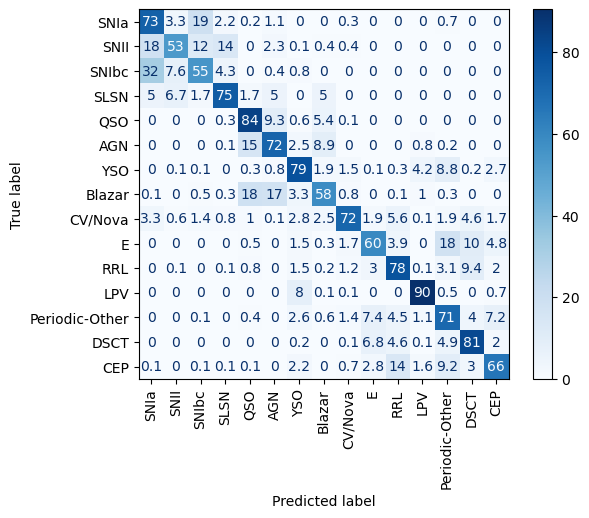

In [28]:

# Display the confusion matrix with approximated values
cm_rounded = np.round(np.mean(matrixes,axis=0), 1)
disp=ConfusionMatrixDisplay(cm_rounded, display_labels=Labels_dict['Complete'])
fig, ax = plt.subplots()
cbar = fig.colorbar(cax, format='%.1e')
cbar.remove()
disp.plot(cmap='Blues',ax=ax)
for label in ax.get_xticklabels():
    label.set_rotation(90)
plt.show()

In [ ]:
n_classes=4
precisions=np.zeros(4)
recalls=np.zeros(4)
f1s=np.zeros(4)
matrixes=np.zeros((4,n_classes,n_classes))
minrecalls=np.zeros(4)
for i in range(4):
    print('iteration '+str(i+1))
    X_train, X_test, X_synth = train_sets[i].copy(), test_sets[i].copy() , synth_sets[i].copy()
    
    y_train=X_train['_y'].copy()
    X_train.drop('_y',axis=1,inplace=True)
    X_train.drop('_lcobj_name',axis=1,inplace=True)
    X_train.drop('_fullsynth',axis=1,inplace=True)
    
    y_test=X_test['_y'].copy()
    X_test.drop('_y',axis=1,inplace=True)
    X_test.drop('_lcobj_name',axis=1,inplace=True)
    X_test.drop('_fullsynth',axis=1,inplace=True)
    
    y_synth=X_synth['_y'].copy()
    X_synth.drop('_y',axis=1,inplace=True)
    X_synth.drop('_lcobj_name',axis=1,inplace=True)
    X_synth.drop('_fullsynth',axis=1,inplace=True)
    
    X_synth[X_synth > 100000] = -999
    X_train[X_train > 100000] = -999
    
    X_train=X_train.fillna(-999)
    X_synth=X_synth.fillna(-999)
    X_test=X_test.fillna(-999)
    
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X_synth, y_synth)
    X_res2, y_res2 = rus.fit_resample(X_train, y_train)
    

    rf_model = BalancedRandomForestClassifier(
                         n_estimators=500,
                         max_features='auto',#'auto',
                         max_depth=None,
                         n_jobs=-1,
                         bootstrap=True,
                         criterion='gini',
                         min_samples_split=10,
                         min_samples_leaf=10)
    rf_model.fit(pd.concat([X_res,X_res2]),pd.concat([y_res,y_res2]))
    preds_test = rf_model.predict(X_test)
    
    classreport=classification_report(y_test,preds_test,output_dict=True)
    precisions[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['precision']
    recalls[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['recall']
    f1s[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['f1-score']
    matrixes[i]=confusion_matrix(y_test,preds_test,normalize='true')
    minrecalls[i]=np.min(recall_score(y_test, preds_test, average=None))
    
    
print('Model: Bootstrapped')
print('Precision: Mean = ' + str(np.mean(precisions)) + '; Std = '+ str(np.std(precisions)))
print('Recall: Mean = ' + str(np.mean(recalls)) + '; Std = '+ str(np.std(recalls)))
print('F1-score: Mean = ' + str(np.mean(f1s)) + '; Std = '+ str(np.std(f1s)))
print('Min recall: Mean = ' + str(np.mean(minrecalls)) + '; Std = '+ str(np.std(minrecalls)))


disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0),display_labels=LabelDict)
disp.plot(cmap='Blues')
plt.show()

# Periodic Max_depth variable, objective metric= recall

iteration 0
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
depth 11
depth 12
depth 13
depth 14
depth 15
depth 16


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 17


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 18
depth 19
depth 20
depth 21
depth 22
depth 23
depth 24
depth 25
iteration 1
depth 1


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 2
depth 3
depth 4


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
depth 11
depth 12
depth 13
depth 14
depth 15
depth 16
depth 17
depth 18
depth 19
depth 20
depth 21
depth 22
depth 23
depth 24
depth 25
iteration 2
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
depth 11
depth 12
depth 13
depth 14
depth 15
depth 16
depth 17
depth 18
depth 19
depth 20
depth 21
depth 22
depth 23
depth 24
depth 25
Model: Periodic_Depth=1
Precision: Mean = 0.35277361856412676; Std = 0.1982550242415629
Recall: Mean = 0.4808317300059046; Std = 0.225212113391958
F1-score: Mean = 0.324291971437376; Std = 0.1592139332333946
Min recall: Mean = 0.24048428651395795; Std = 0.1783925609165907
Mod recall: Mean = 0.42651457432320833; Std = 0.2987149611928792


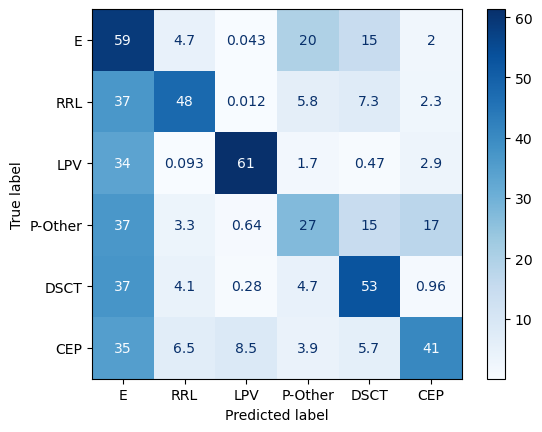

Model: Periodic_Depth=2
Precision: Mean = 0.5231611021898716; Std = 0.009475537999309658
Recall: Mean = 0.745121321577138; Std = 0.02140840495552123
F1-score: Mean = 0.5334893703774523; Std = 0.015199901014881228
Min recall: Mean = 0.5152979066022544; Std = 0.0667160466533546
Mod recall: Mean = 0.7055288316876368; Std = 0.02449096360645663


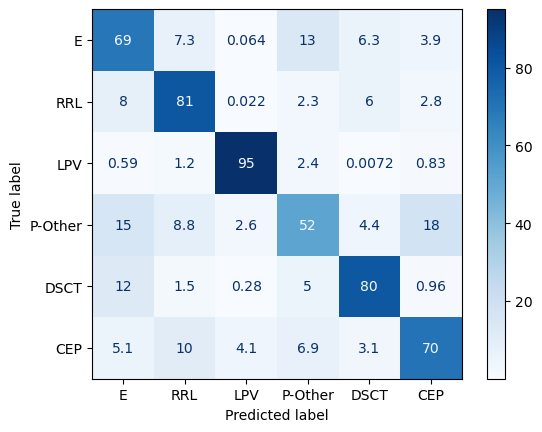

Model: Periodic_Depth=3
Precision: Mean = 0.5339994142323531; Std = 0.01318041673682896
Recall: Mean = 0.7784057572782968; Std = 0.028957412819337225
F1-score: Mean = 0.5481472831721234; Std = 0.023679153649927516
Min recall: Mean = 0.6371047811204372; Std = 0.018095195026430717
Mod recall: Mean = 0.7473250722460483; Std = 0.03418932937182488


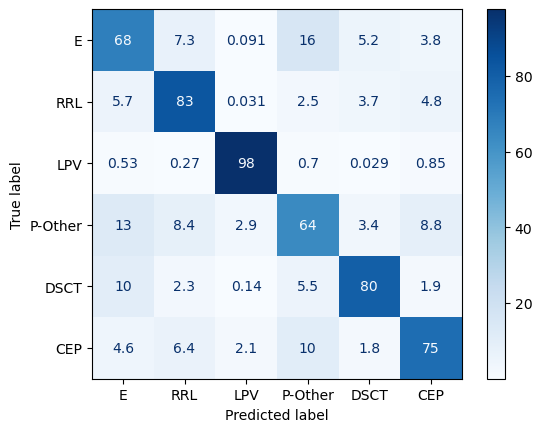

Model: Periodic_Depth=4
Precision: Mean = 0.3896011200376364; Std = 0.2242460257357847
Recall: Mean = 0.5915830161280725; Std = 0.3006173215053615
F1-score: Mean = 0.415397933235265; Std = 0.22244307548179315
Min recall: Mean = 0.43719806763285024; Std = 0.3091472910732499
Mod recall: Mean = 0.5176964346486481; Std = 0.36160072520743936


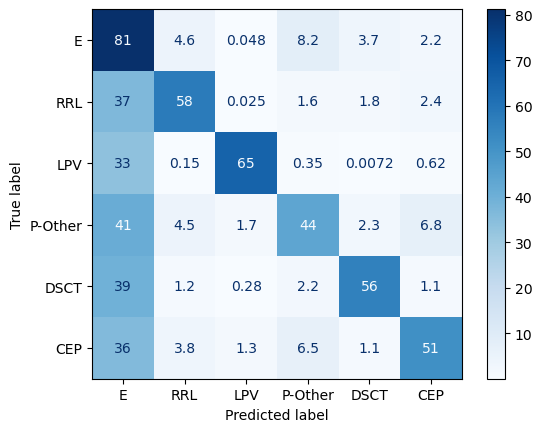

Model: Periodic_Depth=5
Precision: Mean = 0.5784417865771173; Std = 0.01417256953360057
Recall: Mean = 0.8222445776350104; Std = 0.012667801054202382
F1-score: Mean = 0.6180010876502591; Std = 0.020700302863271847
Min recall: Mean = 0.6892109500805152; Std = 0.018640639134927882
Mod recall: Mean = 0.7716573806615871; Std = 0.016950652750185806


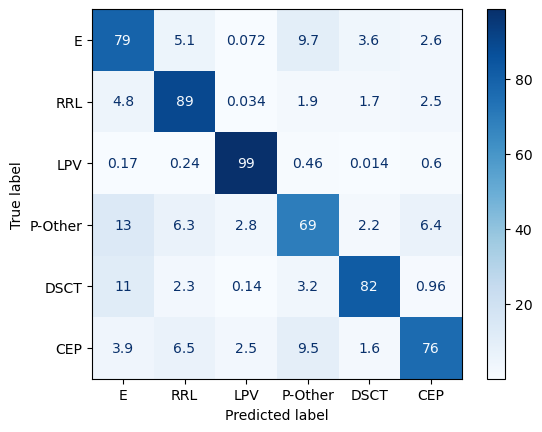

Model: Periodic_Depth=6
Precision: Mean = 0.5976125828660095; Std = 0.016725901045461893
Recall: Mean = 0.8236541028950753; Std = 0.00253728347611193
F1-score: Mean = 0.6430605200306477; Std = 0.020350899332776517
Min recall: Mean = 0.6916264090177133; Std = 0.011214483314963058
Mod recall: Mean = 0.7578373207584294; Std = 0.007584678916081596


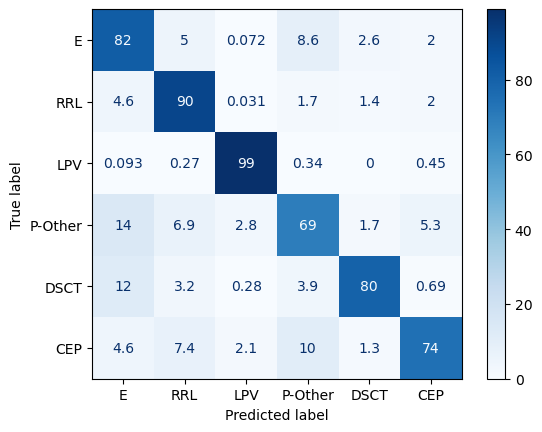

Model: Periodic_Depth=7
Precision: Mean = 0.5741001120874535; Std = 0.016958819825713047
Recall: Mean = 0.7772684159844919; Std = 0.024597627587005243
F1-score: Mean = 0.6114869368599348; Std = 0.023158396042695772
Min recall: Mean = 0.6280193236714976; Std = 0.026679615983544135
Mod recall: Mean = 0.6810789041640731; Std = 0.03844505992684183


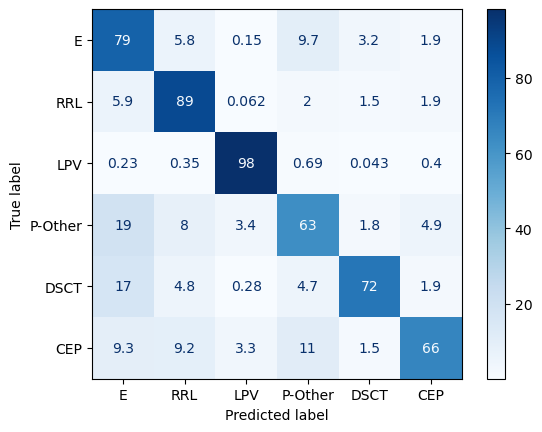

Model: Periodic_Depth=8
Precision: Mean = 0.6267336157120652; Std = 0.03536686565502228
Recall: Mean = 0.8003193398241502; Std = 0.022475326135869937
F1-score: Mean = 0.6724493691721812; Std = 0.04021108348481092
Min recall: Mean = 0.6336553945249598; Std = 0.024501004919006347
Mod recall: Mean = 0.6989572657211433; Std = 0.029892364563150423


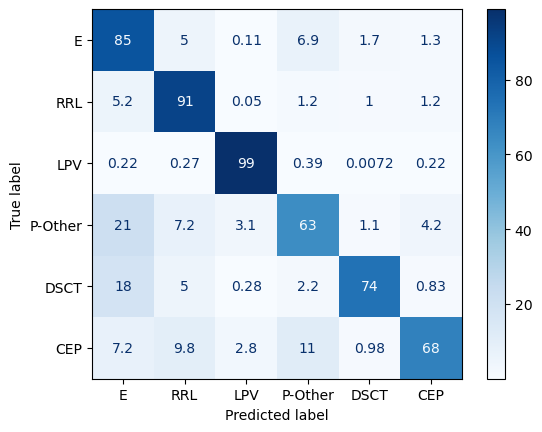

Model: Periodic_Depth=9
Precision: Mean = 0.6609405479938886; Std = 0.019286924412353627
Recall: Mean = 0.8155426989268652; Std = 0.0014419699084981794
F1-score: Mean = 0.709378233672275; Std = 0.017906199991502367
Min recall: Mean = 0.643317230273752; Std = 0.009109266102242145
Mod recall: Mean = 0.7129890594243028; Std = 0.0026408348477366156


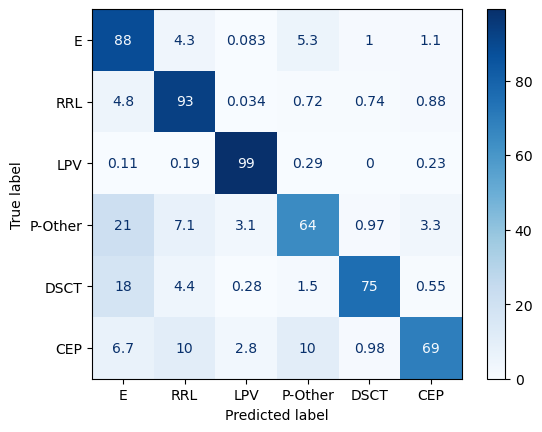

Model: Periodic_Depth=10
Precision: Mean = 0.6550891399428372; Std = 0.04611450508398298
Recall: Mean = 0.7908668151466491; Std = 0.02206256646430541
F1-score: Mean = 0.6974786196953291; Std = 0.04523170548432463
Min recall: Mean = 0.5805152979066022; Std = 0.025359123587799688
Mod recall: Mean = 0.6722395312403724; Std = 0.029560103851500704


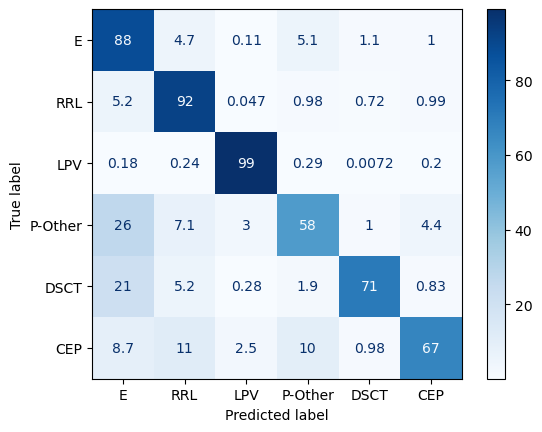

In [23]:
def xgb_recall_score(preds, dtrain):
    y_true = dtrain.get_label()
    preds = preds.reshape(len(np.unique(y_true)), -1)
    preds = np.argmax(preds, axis=0)
    if len(np.unique(preds))<len(np.unique(y_true)):
        return 0
    
    return 'recall_score', -recall_score(y_true,preds,average='macro')

subclass= 'Periodic'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)


n_splits=3
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=[]
recalls=[]
f1s=[]
matrixes=[]
minrecalls=[]
modrecalls=[]
preds_dict=[]
tests_dict=[]
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
    dtrain = xgb.DMatrix(data=X_train, label=y_train
                         ,weight=pd.Series(y_train).map(lambda x: class_weights[x])
                        )
    dvalid = xgb.DMatrix(data=X_test, label=y_test)

    
    precisions_temp=[]
    recalls_temp=[]
    f1s_temp=[]
    matrixes_temp=[]
    minrecalls_temp=[]
    modrecalls_temp=[]
    preds_dict_temp=[]
    tests_dict_temp=[]
    params = Per_par[i]
    for j in range(25):
        print('depth ' + str(j+1))
        params['max_depth'] = j+1
        watchlist = [(dtrain, 'train')]
        gbm_model = xgb.train(params, dtrain, 500,
                                  evals=watchlist,
                                  verbose_eval=False,
                                  custom_metric=xgb_recall_score,
                                  early_stopping_rounds=15)
        preds = gbm_model.predict(dvalid,
                                            iteration_range=(1,gbm_model.best_iteration + 1))
        for k in range(len(preds)):
            preds[k] = np.exp(preds[k])/np.sum(np.exp(preds[k]))
        preds_test = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)

        precisions_temp.append(precision_score(y_test,preds_test,average='macro'))
        recalls_temp.append(recall_score(y_test,preds_test,average='macro'))
        f1s_temp.append(f1_score(y_test,preds_test,average='macro'))
        matrixes_temp.append(confusion_matrix(y_test,preds_test,normalize='true')*100)
        minrecalls_temp.append(np.min(recall_score(y_test, preds_test, average=None)))
        modrecalls_temp.append(recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True))))
        
        preds_dict_temp.append(preds)
        tests_dict_temp.append(y_test)
    precisions.append(precisions_temp)
    recalls.append(recalls_temp)
    f1s.append(f1s_temp)
    matrixes.append(matrixes_temp)
    minrecalls.append(minrecalls_temp)
    modrecalls.append(modrecalls_temp)    
    preds_dict.append(preds_dict_temp)
    tests_dict.append(tests_dict_temp)
    i=i+1
file_name = 'ResultadosFinales/Periodic_Recall_MaxDepthVar_Preds_depth_testeoconcustommetric.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Periodic_Recall_MaxDepthVar_Tests_depth_testeoconcustommetric.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)

for k in range(10):
    
    print('Model: Periodic_Depth='+str(k+1))
    print('Precision: Mean = ' + str(np.mean(precisions,axis=0)[k]) + '; Std = '+ str(np.std(precisions,axis=0)[k]))
    print('Recall: Mean = ' + str(np.mean(recalls,axis=0)[k]) + '; Std = '+ str(np.std(recalls,axis=0)[k]))
    print('F1-score: Mean = ' + str(np.mean(f1s,axis=0)[k]) + '; Std = '+ str(np.std(f1s,axis=0)[k]))
    print('Min recall: Mean = ' + str(np.mean(minrecalls,axis=0)[k]) + '; Std = '+ str(np.std(minrecalls,axis=0)[k]))
    print('Mod recall: Mean = ' + str(np.mean(modrecalls,axis=0)[k]) + '; Std = '+ str(np.std(modrecalls,axis=0)[k]))


    disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0)[k], display_labels=Labels_dict[subclass])
    disp.plot(cmap='Blues')
    plt.show()

iteration 0
depth 1
depth 2
depth 3
depth 4
depth 5


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 6
depth 7
depth 8
depth 9
depth 10
depth 11
depth 12
depth 13
depth 14
depth 15
iteration 1
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
depth 11
depth 12
depth 13
depth 14
depth 15
iteration 2
depth 1
depth 2
depth 3


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 4
depth 5
depth 6


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 7


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 8
depth 9
depth 10
depth 11


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 12


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 13


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 14


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


depth 15
Model: Periodic_Depth=1
Precision: Mean = 0.4871228853170742; Std = 0.013787001965562864
Recall: Mean = 0.6551835334494219; Std = 0.01647318836016122
F1-score: Mean = 0.44364826214166725; Std = 0.02079996809749482
Min recall: Mean = 0.3646109646026221; Std = 0.08192894917224541
Mod recall: Mean = 0.6328053528926633; Std = 0.04346710773546681


C:\Users\vicen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


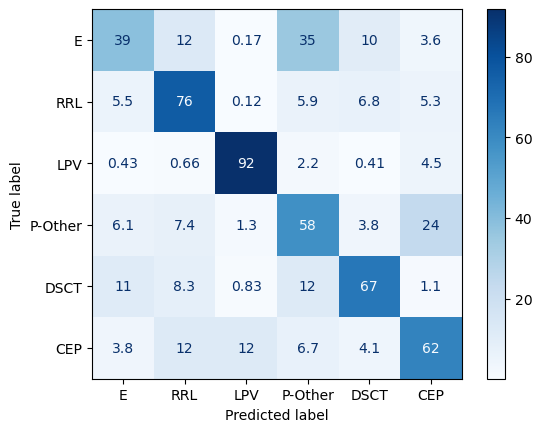

Model: Periodic_Depth=2
Precision: Mean = 0.5317086540820356; Std = 0.010547823187796058
Recall: Mean = 0.7589475673908708; Std = 0.023666637679923847
F1-score: Mean = 0.54628217011216; Std = 0.01684874787436677
Min recall: Mean = 0.5475040257648953; Std = 0.06615986661569769
Mod recall: Mean = 0.7170146470222728; Std = 0.029531313761052582


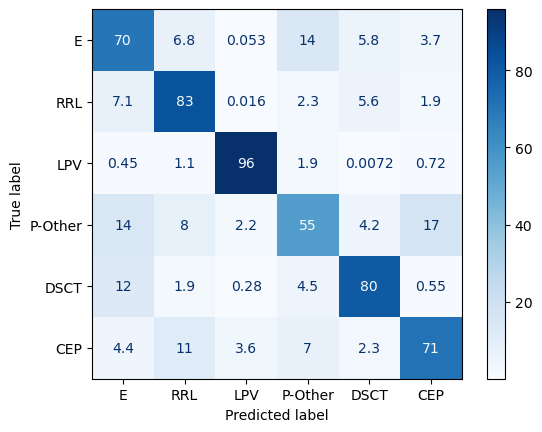

Model: Periodic_Depth=3
Precision: Mean = 0.38047759792872055; Std = 0.21780671169006563
Recall: Mean = 0.5788397939896358; Std = 0.2916111555351064
F1-score: Mean = 0.4006287054447353; Std = 0.21206228118238676
Min recall: Mean = 0.42834138486312395; Std = 0.3032937638330103
Mod recall: Mean = 0.5047067121541637; Std = 0.3522361862988562


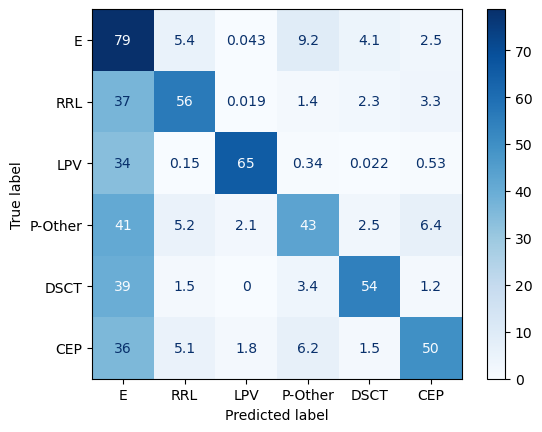

Model: Periodic_Depth=4
Precision: Mean = 0.5520268436495449; Std = 0.012479709292825755
Recall: Mean = 0.8024132326542616; Std = 0.013337851173132857
F1-score: Mean = 0.577377447381426; Std = 0.0210439746196978
Min recall: Mean = 0.6634460547504025; Std = 0.020716071385295666
Mod recall: Mean = 0.7661116968067382; Std = 0.006922996619257827


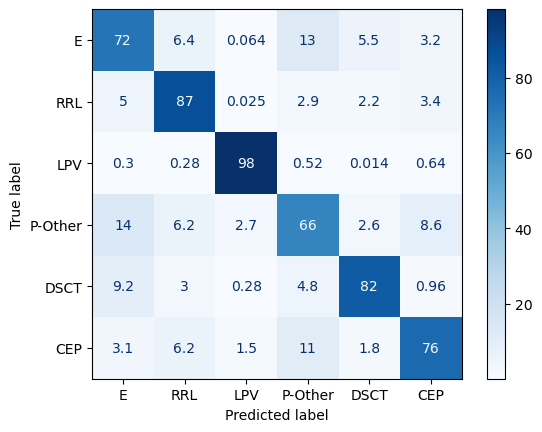

Model: Periodic_Depth=5
Precision: Mean = 0.4066136025343954; Std = 0.23747006728809464
Recall: Mean = 0.5938193489809146; Std = 0.3025208469730219
F1-score: Mean = 0.43951446826515816; Std = 0.24189101361928597
Min recall: Mean = 0.4363929146537842; Std = 0.30908647308057036
Mod recall: Mean = 0.5051069096100995; Std = 0.35255981220438487


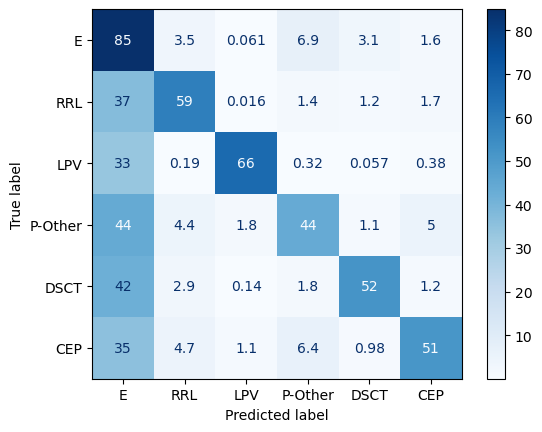

Model: Periodic_Depth=6
Precision: Mean = 0.435584013022765; Std = 0.2571816208383872
Recall: Mean = 0.6100323897301002; Std = 0.3135069871256798
F1-score: Mean = 0.47828357797213245; Std = 0.2673193816672314
Min recall: Mean = 0.4573268921095008; Std = 0.3235292626969349
Mod recall: Mean = 0.5111570969693999; Std = 0.35670462817620135


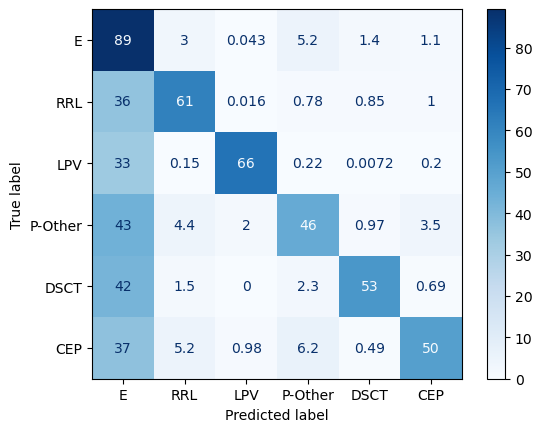

Model: Periodic_Depth=7
Precision: Mean = 0.4519559880665311; Std = 0.2696645357336489
Recall: Mean = 0.607309820219802; Std = 0.31159560247746815
F1-score: Mean = 0.49432375544889356; Std = 0.2794570247484825
Min recall: Mean = 0.4388083735909823; Std = 0.31032354815783836
Mod recall: Mean = 0.5008925633605973; Std = 0.3494200792303959


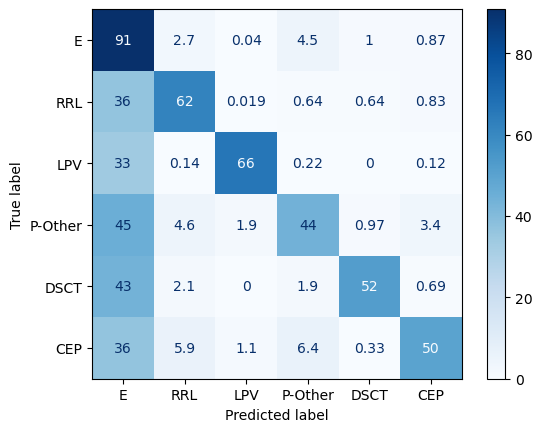

Model: Periodic_Depth=8
Precision: Mean = 0.6534078419729877; Std = 0.021286083830577972
Recall: Mean = 0.821217122130706; Std = 0.013548422296778316
F1-score: Mean = 0.7029941605263956; Std = 0.02279810586088793
Min recall: Mean = 0.6570048309178743; Std = 0.019019342690849764
Mod recall: Mean = 0.7283393676532626; Std = 0.01694372773228717


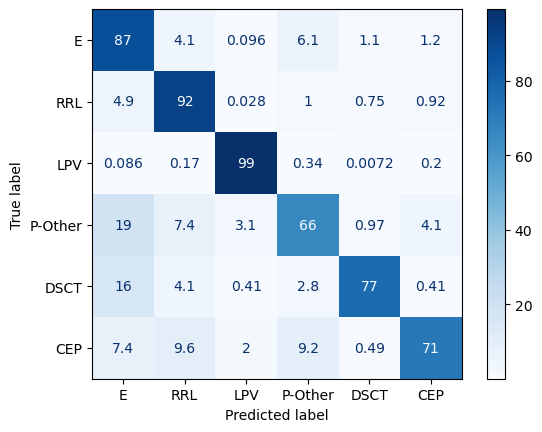

Model: Periodic_Depth=9
Precision: Mean = 0.6533982786879148; Std = 0.020875071654880437
Recall: Mean = 0.8132316880115659; Std = 0.01519135015823115
F1-score: Mean = 0.7019552796961559; Std = 0.022325822027038852
Min recall: Mean = 0.6320450885668277; Std = 0.014267347139025253
Mod recall: Mean = 0.7140811676929802; Std = 0.02187870610331231


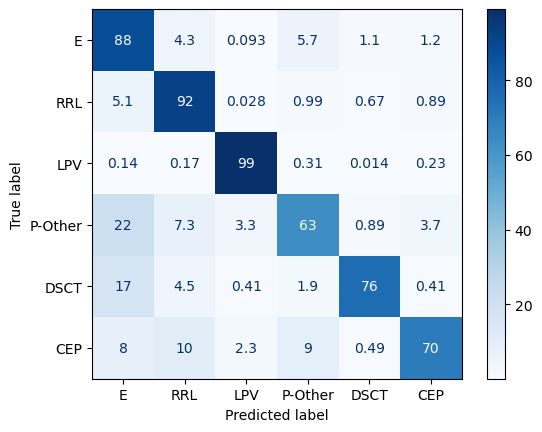

Model: Periodic_Depth=10
Precision: Mean = 0.6812045869229871; Std = 0.04194242807997393
Recall: Mean = 0.8122710164698993; Std = 0.013203544289834286
F1-score: Mean = 0.7247612725494795; Std = 0.03796189354281995
Min recall: Mean = 0.6231884057971016; Std = 0.013805497745154797
Mod recall: Mean = 0.7033250413741626; Std = 0.012083361831908208


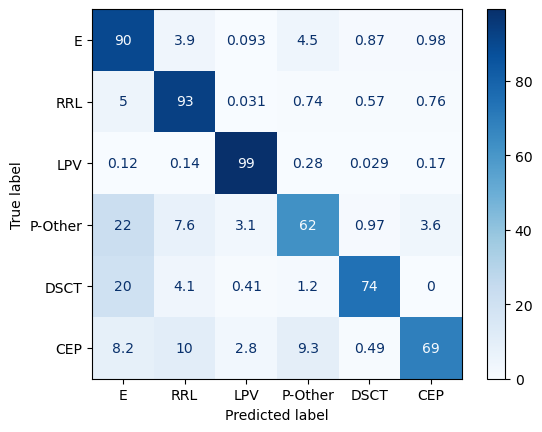

In [22]:
def xgb_recall_score(preds, dtrain):
    y_true = dtrain.get_label()
    preds = preds.reshape(len(np.unique(y_true)), -1)
    preds = np.argmax(preds, axis=0)
    if len(np.unique(preds))<len(np.unique(y_true)):
        return 0
    
    return 'recall_score', recall_score(y_true,preds,average='macro')

subclass= 'Periodic'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)


n_splits=3
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=[]
recalls=[]
f1s=[]
matrixes=[]
minrecalls=[]
modrecalls=[]
preds_dict=[]
tests_dict=[]
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
    dtrain = xgb.DMatrix(data=X_train, label=y_train
                         ,weight=pd.Series(y_train).map(lambda x: class_weights[x])
                        )
    dvalid = xgb.DMatrix(data=X_test, label=y_test)

    
    precisions_temp=[]
    recalls_temp=[]
    f1s_temp=[]
    matrixes_temp=[]
    minrecalls_temp=[]
    modrecalls_temp=[]
    preds_dict_temp=[]
    tests_dict_temp=[]
    params = Per_par[i]
    for j in range(15):
        print('depth ' + str(j+1))
        params['max_depth'] = j+1
        watchlist = [(dtrain, 'train')]
        gbm_model = xgb.train(params, dtrain, 500,
                                  evals=watchlist,
                                  verbose_eval=False,
                                  custom_metric=xgb_recall_score,
                                  early_stopping_rounds=15)
        preds = gbm_model.predict(dvalid,
                                            iteration_range=(1,gbm_model.best_iteration + 1))
        for k in range(len(preds)):
            preds[k] = np.exp(preds[k])/np.sum(np.exp(preds[k]))
        preds_test = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)

        precisions_temp.append(precision_score(y_test,preds_test,average='macro'))
        recalls_temp.append(recall_score(y_test,preds_test,average='macro'))
        f1s_temp.append(f1_score(y_test,preds_test,average='macro'))
        matrixes_temp.append(confusion_matrix(y_test,preds_test,normalize='true')*100)
        minrecalls_temp.append(np.min(recall_score(y_test, preds_test, average=None)))
        modrecalls_temp.append(recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True))))
        
        preds_dict_temp.append(preds)
        tests_dict_temp.append(y_test)
    precisions.append(precisions_temp)
    recalls.append(recalls_temp)
    f1s.append(f1s_temp)
    matrixes.append(matrixes_temp)
    minrecalls.append(minrecalls_temp)
    modrecalls.append(modrecalls_temp)    
    preds_dict.append(preds_dict_temp)
    tests_dict.append(tests_dict_temp)
    i=i+1
file_name = 'ResultadosFinales/Periodic_Recall_MaxDepthVar_Preds_depth_testeoconcustommetric2.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Periodic_Recall_MaxDepthVar_Tests_depth_testeoconcustommetric2.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)

for k in range(10):
    
    print('Model: Periodic_Depth='+str(k+1))
    print('Precision: Mean = ' + str(np.mean(precisions,axis=0)[k]) + '; Std = '+ str(np.std(precisions,axis=0)[k]))
    print('Recall: Mean = ' + str(np.mean(recalls,axis=0)[k]) + '; Std = '+ str(np.std(recalls,axis=0)[k]))
    print('F1-score: Mean = ' + str(np.mean(f1s,axis=0)[k]) + '; Std = '+ str(np.std(f1s,axis=0)[k]))
    print('Min recall: Mean = ' + str(np.mean(minrecalls,axis=0)[k]) + '; Std = '+ str(np.std(minrecalls,axis=0)[k]))
    print('Mod recall: Mean = ' + str(np.mean(modrecalls,axis=0)[k]) + '; Std = '+ str(np.std(modrecalls,axis=0)[k]))


    disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0)[k], display_labels=Labels_dict[subclass])
    disp.plot(cmap='Blues')
    plt.show()

# Stochastic Max_depth variable, objective metric= mod_recall

iteration 0
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 1
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 2
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 3
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 4
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 5
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 6
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 7
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 8
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 9
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
Model: Stochastic_Depth=1
Precision: Mean = 0.7227234897046804; Std = 

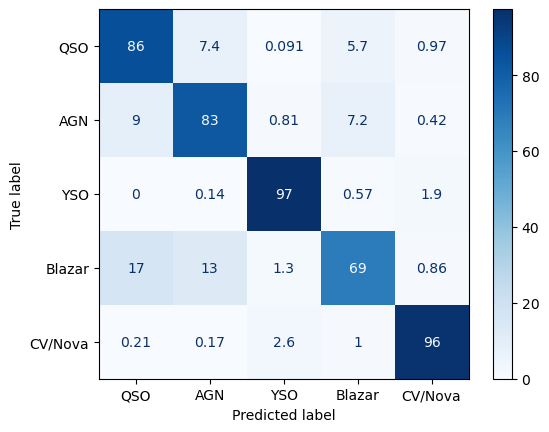

Model: Stochastic_Depth=2
Precision: Mean = 0.7794954072598121; Std = 0.0051721923891231555
Recall: Mean = 0.8798737335276318; Std = 0.004020802397542992
F1-score: Mean = 0.8160824690600398; Std = 0.0040409168556621465
Min recall: Mean = 0.722488038277512; Std = 0.023610391945407334
Mod recall: Mean = 0.8892937413160329; Std = 0.0068797905792563905


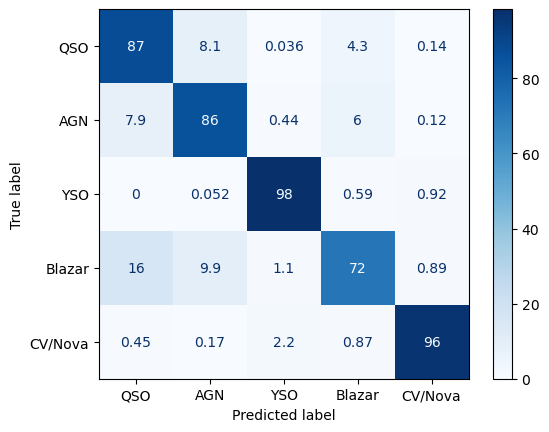

Model: Stochastic_Depth=3
Precision: Mean = 0.8009425408468722; Std = 0.005649253758912614
Recall: Mean = 0.8849225250920533; Std = 0.0037357691151963936
F1-score: Mean = 0.8334161692840107; Std = 0.004570119835819096
Min recall: Mean = 0.7193779904306219; Std = 0.023465716829098298
Mod recall: Mean = 0.8897460674338961; Std = 0.0057682704866803105


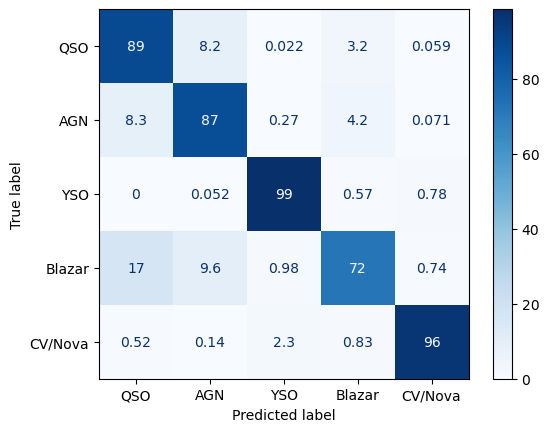

Model: Stochastic_Depth=4
Precision: Mean = 0.8230928068324266; Std = 0.0054106095406392055
Recall: Mean = 0.8862853200445716; Std = 0.004450399442689514
F1-score: Mean = 0.8491742169162022; Std = 0.004394729017810656
Min recall: Mean = 0.7052631578947369; Std = 0.026592714318833022
Mod recall: Mean = 0.8864461419038904; Std = 0.006524439848165213


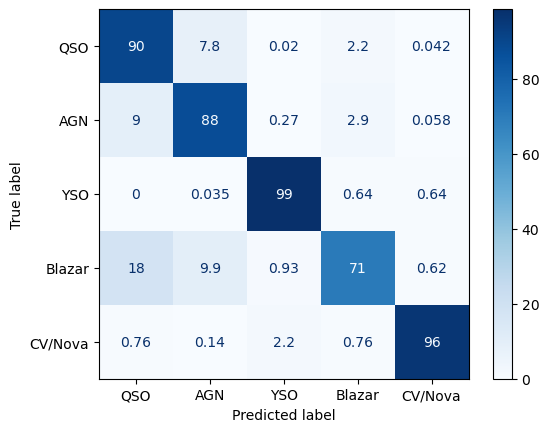

Model: Stochastic_Depth=5
Precision: Mean = 0.8410581450935458; Std = 0.004825390218217671
Recall: Mean = 0.883780928773381; Std = 0.003683257492073379
F1-score: Mean = 0.8589868347141174; Std = 0.0036793605482781096
Min recall: Mean = 0.6863636363636363; Std = 0.023621297718654788
Mod recall: Mean = 0.8799598979028163; Std = 0.0062177566357579225


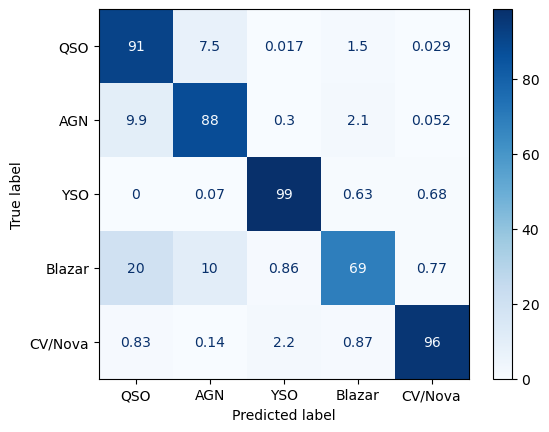

Model: Stochastic_Depth=6
Precision: Mean = 0.852818977793501; Std = 0.005831266870706784
Recall: Mean = 0.8820676642924259; Std = 0.004057984534397323
F1-score: Mean = 0.8643933609809562; Std = 0.004370313712954734
Min recall: Mean = 0.6720095693779904; Std = 0.024941267058831294
Mod recall: Mean = 0.8764442696554378; Std = 0.006696307887163516


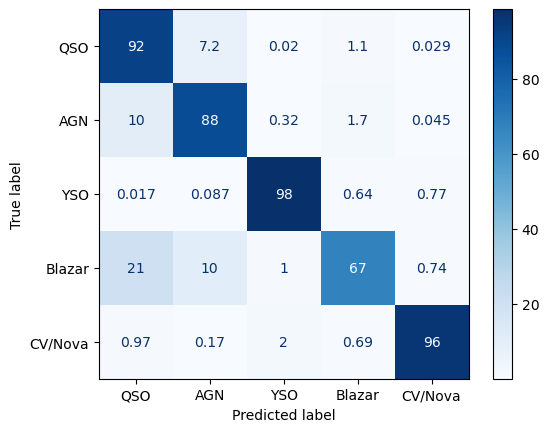

Model: Stochastic_Depth=7
Precision: Mean = 0.8597045415035712; Std = 0.0052676893063794685
Recall: Mean = 0.8812686441792333; Std = 0.004789408527005586
F1-score: Mean = 0.8675786077981782; Std = 0.004786361132632985
Min recall: Mean = 0.667464114832536; Std = 0.023219302504403686
Mod recall: Mean = 0.8745621530041052; Std = 0.007959669605285132


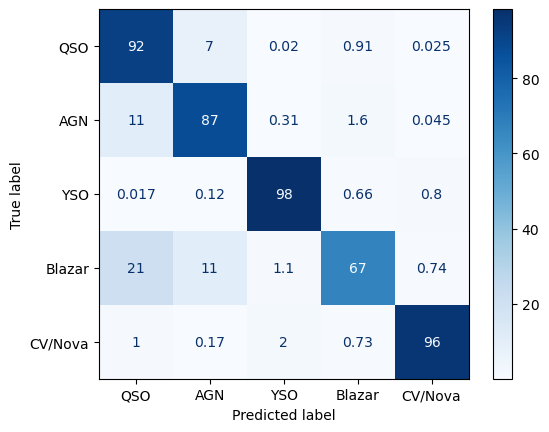

Model: Stochastic_Depth=8
Precision: Mean = 0.8638814298197875; Std = 0.004364283180500651
Recall: Mean = 0.8795883427231714; Std = 0.0031818338254229195
F1-score: Mean = 0.8689021905134421; Std = 0.0036520862607099087
Min recall: Mean = 0.6614832535885167; Std = 0.021377709858387654
Mod recall: Mean = 0.8723221472402913; Std = 0.005458037978745163


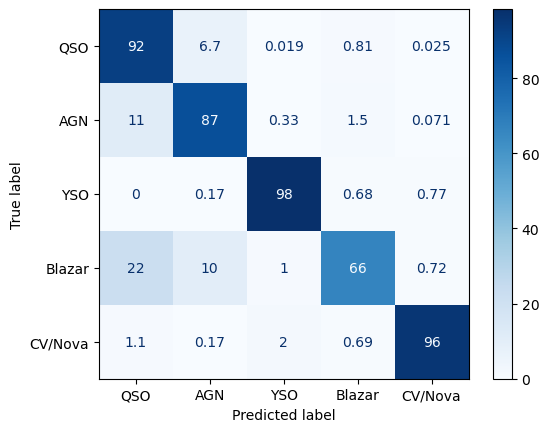

Model: Stochastic_Depth=9
Precision: Mean = 0.8660756789062676; Std = 0.005064577945938046
Recall: Mean = 0.8774731471734697; Std = 0.0035250141862291488
F1-score: Mean = 0.8690143390520951; Std = 0.004040901703617012
Min recall: Mean = 0.6526315789473685; Std = 0.02186869833880657
Mod recall: Mean = 0.8695128846137277; Std = 0.005907258708190636


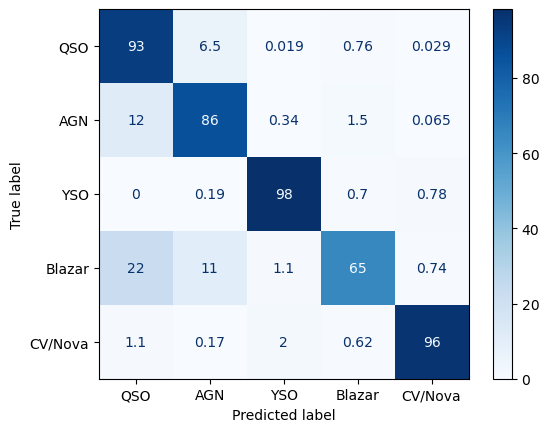

Model: Stochastic_Depth=10
Precision: Mean = 0.8703731026975765; Std = 0.005045571429713945
Recall: Mean = 0.8760654824518997; Std = 0.0038233878138429164
F1-score: Mean = 0.8704116180495018; Std = 0.003896467139943696
Min recall: Mean = 0.6473684210526316; Std = 0.022876618350013263
Mod recall: Mean = 0.8675921111975835; Std = 0.006786957787007072


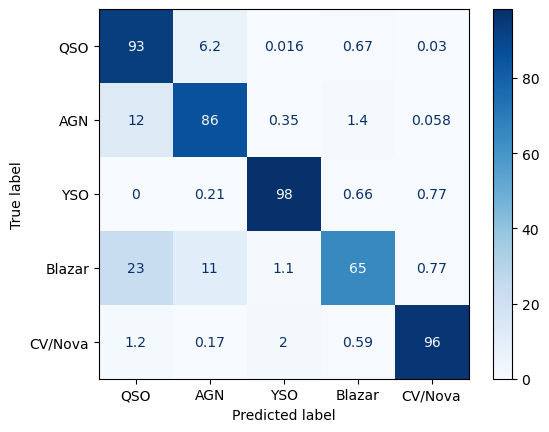

In [44]:

subclass= 'Stochastic'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)


n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=[]
recalls=[]
f1s=[]
matrixes=[]
minrecalls=[]
modrecalls=[]
preds_dict=[]
tests_dict=[]
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
    dtrain = xgb.DMatrix(data=X_train, label=y_train
                         ,weight=pd.Series(y_train).map(lambda x: class_weights[x])
                        )
    dvalid = xgb.DMatrix(data=X_test, label=y_test)

    
    precisions_temp=[]
    recalls_temp=[]
    f1s_temp=[]
    matrixes_temp=[]
    minrecalls_temp=[]
    modrecalls_temp=[]
    preds_dict_temp=[]
    tests_dict_temp=[]
    params = {'colsample_bytree': 0.9500000000000001, 'eta': 0.025, 'gamma': 1.5, 'max_depth': 3, 'min_child_weight': 6.0, 'subsample': 1.0, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'booster': 'gbtree', 'tree_method': 'gpu_hist', 'num_class': 5}
    for j in range(10):
        print('depth ' + str(j+1))
        params['max_depth'] = j+1
        watchlist = [(dtrain, 'train')]
        gbm_model = xgb.train(params, dtrain, 500,
                                  evals=watchlist,
                                  verbose_eval=False,
                                  early_stopping_rounds=15)
        preds = gbm_model.predict(dvalid,
                                            iteration_range=(1,gbm_model.best_iteration + 1))
        for k in range(len(preds)):
            preds[k] = np.exp(preds[k])/np.sum(np.exp(preds[k]))
        preds_test = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)

        precisions_temp.append(precision_score(y_test,preds_test,average='macro'))
        recalls_temp.append(recall_score(y_test,preds_test,average='macro'))
        f1s_temp.append(f1_score(y_test,preds_test,average='macro'))
        matrixes_temp.append(confusion_matrix(y_test,preds_test,normalize='true')*100)
        minrecalls_temp.append(np.min(recall_score(y_test, preds_test, average=None)))
        modrecalls_temp.append(recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True))))
        
        preds_dict_temp.append(preds)
        tests_dict_temp.append(y_test)
    precisions.append(precisions_temp)
    recalls.append(recalls_temp)
    f1s.append(f1s_temp)
    matrixes.append(matrixes_temp)
    minrecalls.append(minrecalls_temp)
    modrecalls.append(modrecalls_temp)    
    preds_dict.append(preds_dict_temp)
    tests_dict.append(tests_dict_temp)
    i=i+1
file_name = 'ResultadosFinales/Stochastic_Recall_MaxDepthVar_Preds_depth.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Stochastic_Recall_MaxDepthVar_Tests_depth.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)

for k in range(10):
    
    print('Model: Stochastic_Depth='+str(k+1))
    print('Precision: Mean = ' + str(np.mean(precisions,axis=0)[k]) + '; Std = '+ str(np.std(precisions,axis=0)[k]))
    print('Recall: Mean = ' + str(np.mean(recalls,axis=0)[k]) + '; Std = '+ str(np.std(recalls,axis=0)[k]))
    print('F1-score: Mean = ' + str(np.mean(f1s,axis=0)[k]) + '; Std = '+ str(np.std(f1s,axis=0)[k]))
    print('Min recall: Mean = ' + str(np.mean(minrecalls,axis=0)[k]) + '; Std = '+ str(np.std(minrecalls,axis=0)[k]))
    print('Mod recall: Mean = ' + str(np.mean(modrecalls,axis=0)[k]) + '; Std = '+ str(np.std(modrecalls,axis=0)[k]))


    disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0)[k], display_labels=Labels_dict[subclass])
    disp.plot(cmap='Blues')
    plt.show()

# Transient Max_depth variable, objective metric= recall

iteration 0
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 1
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 2
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 3
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 4
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 5
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 6
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 7
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 8
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 9
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
Model: Transient_Depth=1
Precision: Mean = 0.5526617743502995; Std = 0

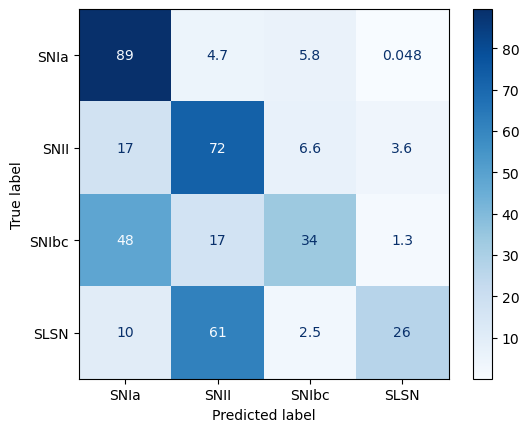

Model: Transient_Depth=2
Precision: Mean = 0.5715412061767052; Std = 0.04882095435579351
Recall: Mean = 0.5440324714115037; Std = 0.03901736510739345
F1-score: Mean = 0.5530425179178382; Std = 0.04185006235305255
Min recall: Mean = 0.1975806451612903; Std = 0.09180806110166263
Mod recall: Mean = 0.2884070459998393; Std = 0.09704228147269386


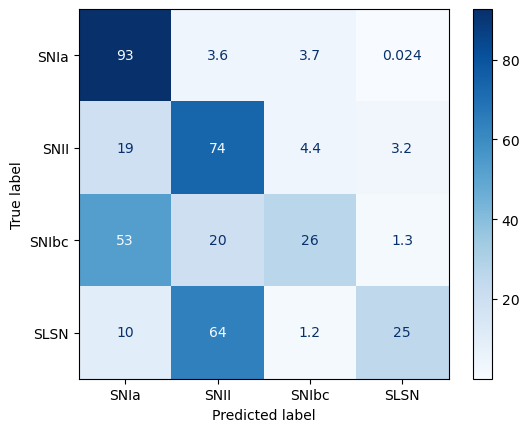

Model: Transient_Depth=3
Precision: Mean = 0.5746510951689933; Std = 0.04276867286704567
Recall: Mean = 0.5428280209933435; Std = 0.03972905755827843
F1-score: Mean = 0.5539928474489154; Std = 0.04015242969454526
Min recall: Mean = 0.20161290322580644; Std = 0.09485667484002672
Mod recall: Mean = 0.29388688130267593; Std = 0.10173259436776329


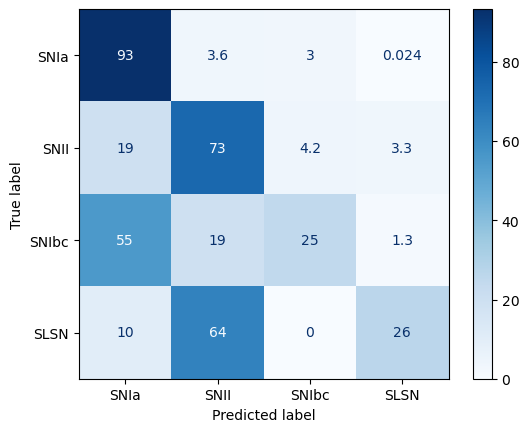

Model: Transient_Depth=4
Precision: Mean = 0.5923566720754454; Std = 0.03299969700914997
Recall: Mean = 0.5552791645331968; Std = 0.03925446108558479
F1-score: Mean = 0.5684364048865904; Std = 0.03765413516848141
Min recall: Mean = 0.22943548387096774; Std = 0.07449207997625215
Mod recall: Mean = 0.31623423948315943; Std = 0.09200685756185983


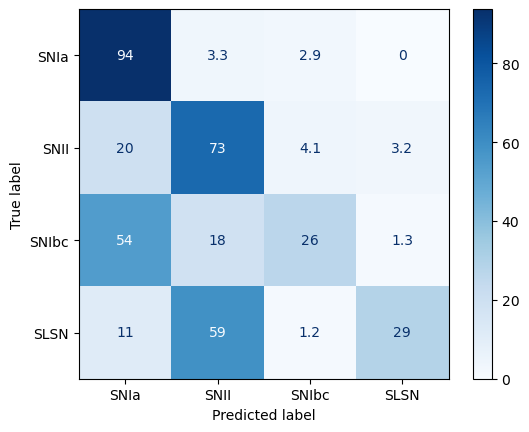

Model: Transient_Depth=5
Precision: Mean = 0.5923237906555459; Std = 0.03225753770068367
Recall: Mean = 0.5554607228195938; Std = 0.03933401281703633
F1-score: Mean = 0.5684352197795725; Std = 0.03695526162256024
Min recall: Mean = 0.21088709677419354; Std = 0.06747378764179827
Mod recall: Mean = 0.3305662716063147; Std = 0.10021704043057139


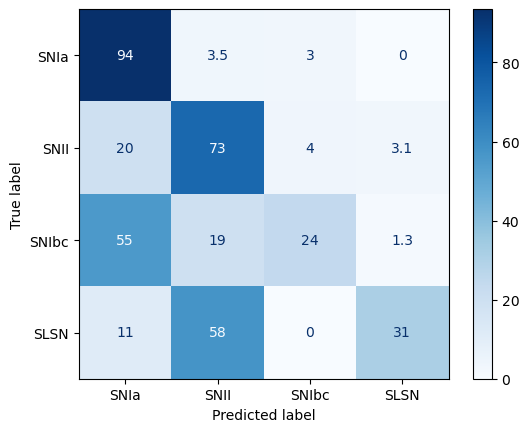

Model: Transient_Depth=6
Precision: Mean = 0.585023194658123; Std = 0.03301235773892672
Recall: Mean = 0.5428412485065711; Std = 0.0251395414510881
F1-score: Mean = 0.5568777986489635; Std = 0.024490688974855374
Min recall: Mean = 0.2004032258064516; Std = 0.0596733324668592
Mod recall: Mean = 0.293813368255117; Std = 0.07647451234686518


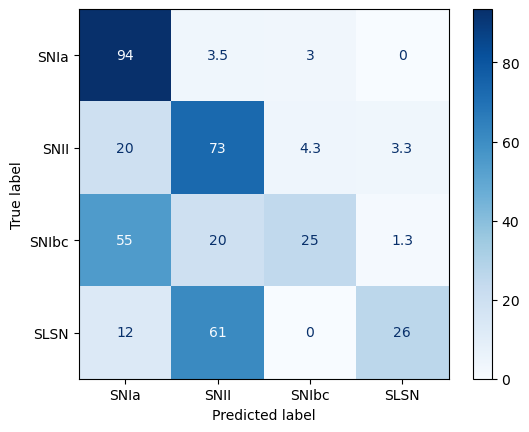

Model: Transient_Depth=7
Precision: Mean = 0.5920546663463422; Std = 0.03665726220844686
Recall: Mean = 0.5488068569721796; Std = 0.03642862176855101
F1-score: Mean = 0.5632763030433087; Std = 0.03481722415211978
Min recall: Mean = 0.21733870967741936; Std = 0.07299278149134963
Mod recall: Mean = 0.3123040396507873; Std = 0.07987799650705305


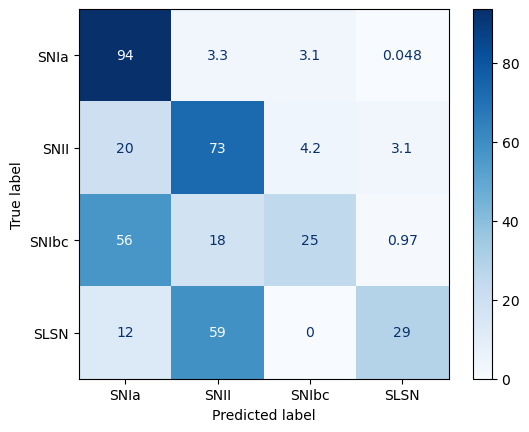

Model: Transient_Depth=8
Precision: Mean = 0.5919819715113522; Std = 0.0341456327772874
Recall: Mean = 0.5536006571087217; Std = 0.037760091835176694
F1-score: Mean = 0.5673018968577589; Std = 0.035809529678586825
Min recall: Mean = 0.217741935483871; Std = 0.07667654402583687
Mod recall: Mean = 0.3368402394829645; Std = 0.08057891996748501


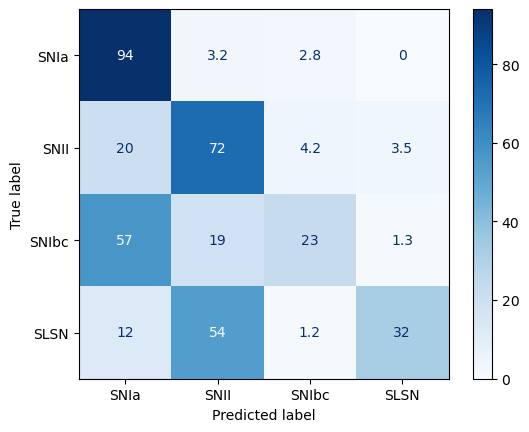

Model: Transient_Depth=9
Precision: Mean = 0.5882266680888202; Std = 0.04058688072371502
Recall: Mean = 0.5465598864994027; Std = 0.03309265613979548
F1-score: Mean = 0.5601558014577888; Std = 0.03331052489484696
Min recall: Mean = 0.18830645161290321; Std = 0.057111636939255854
Mod recall: Mean = 0.310108737995373; Std = 0.09143036066777524


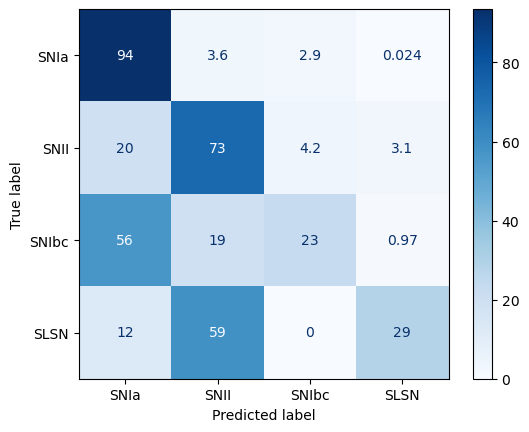

Model: Transient_Depth=10
Precision: Mean = 0.5827095989988884; Std = 0.031963619230755184
Recall: Mean = 0.5441950418160096; Std = 0.03360685894441903
F1-score: Mean = 0.5579832390341585; Std = 0.03211897287423457
Min recall: Mean = 0.19838709677419353; Std = 0.08403752073174706
Mod recall: Mean = 0.30135039618919796; Std = 0.08322105092636568


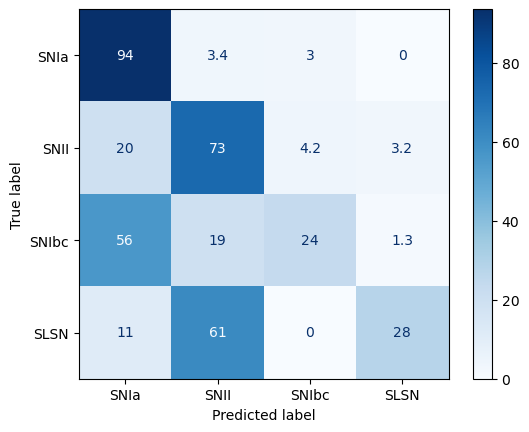

In [45]:

subclass= 'Transient'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)


n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=[]
recalls=[]
f1s=[]
matrixes=[]
minrecalls=[]
modrecalls=[]
preds_dict=[]
tests_dict=[]
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
    dtrain = xgb.DMatrix(data=X_train, label=y_train
                         ,weight=pd.Series(y_train).map(lambda x: class_weights[x])
                        )
    dvalid = xgb.DMatrix(data=X_test, label=y_test)

    
    precisions_temp=[]
    recalls_temp=[]
    f1s_temp=[]
    matrixes_temp=[]
    minrecalls_temp=[]
    modrecalls_temp=[]
    preds_dict_temp=[]
    tests_dict_temp=[]
    params = {'colsample_bytree': 0.9, 'eta': 0.1, 'gamma': 1.3, 'min_child_weight': 4.0, 'subsample': 0.6000000000000001, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'booster': 'gbtree', 'tree_method': 'gpu_hist', 'num_class': 4}
    for j in range(10):
        print('depth ' + str(j+1))
        params['max_depth'] = j+1
        watchlist = [(dtrain, 'train')]
        gbm_model = xgb.train(params, dtrain, 500,
                                  evals=watchlist,
                                  verbose_eval=False,
                                  early_stopping_rounds=15)
        preds = gbm_model.predict(dvalid,
                                            iteration_range=(1,gbm_model.best_iteration + 1))
        for k in range(len(preds)):
            preds[k] = np.exp(preds[k])/np.sum(np.exp(preds[k]))
        preds_test = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)

        precisions_temp.append(precision_score(y_test,preds_test,average='macro'))
        recalls_temp.append(recall_score(y_test,preds_test,average='macro'))
        f1s_temp.append(f1_score(y_test,preds_test,average='macro'))
        matrixes_temp.append(confusion_matrix(y_test,preds_test,normalize='true')*100)
        minrecalls_temp.append(np.min(recall_score(y_test, preds_test, average=None)))
        modrecalls_temp.append(recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True))))
        
        preds_dict_temp.append(preds)
        tests_dict_temp.append(y_test)
    precisions.append(precisions_temp)
    recalls.append(recalls_temp)
    f1s.append(f1s_temp)
    matrixes.append(matrixes_temp)
    minrecalls.append(minrecalls_temp)
    modrecalls.append(modrecalls_temp)    
    preds_dict.append(preds_dict_temp)
    tests_dict.append(tests_dict_temp)
    i=i+1
file_name = 'ResultadosFinales/Transient_Recall_MaxDepthVar_Preds_depth.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Transient_Recall_MaxDepthVar_Tests_depth.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)

for k in range(10):
    
    print('Model: Transient_Depth='+str(k+1))
    print('Precision: Mean = ' + str(np.mean(precisions,axis=0)[k]) + '; Std = '+ str(np.std(precisions,axis=0)[k]))
    print('Recall: Mean = ' + str(np.mean(recalls,axis=0)[k]) + '; Std = '+ str(np.std(recalls,axis=0)[k]))
    print('F1-score: Mean = ' + str(np.mean(f1s,axis=0)[k]) + '; Std = '+ str(np.std(f1s,axis=0)[k]))
    print('Min recall: Mean = ' + str(np.mean(minrecalls,axis=0)[k]) + '; Std = '+ str(np.std(minrecalls,axis=0)[k]))
    print('Mod recall: Mean = ' + str(np.mean(modrecalls,axis=0)[k]) + '; Std = '+ str(np.std(modrecalls,axis=0)[k]))


    disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0)[k], display_labels=Labels_dict[subclass])
    disp.plot(cmap='Blues')
    plt.show()

# Transient Max_depth variable, objective metric= mod_recall v2

iteration 0
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 1
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 2
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 3
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 4
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 5
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 6
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 7
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 8
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
iteration 9
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
Model: Transient_Depth=1
Precision: Mean = 0.5467185178880931; Std = 0

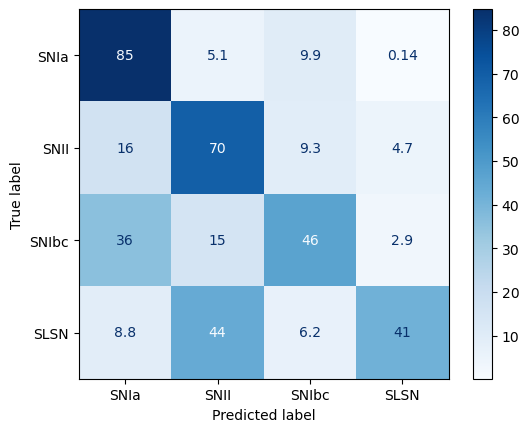

Model: Transient_Depth=2
Precision: Mean = 0.5726660124857228; Std = 0.0327738913933334
Recall: Mean = 0.555926779313876; Std = 0.03258622815516674
F1-score: Mean = 0.5602737423789147; Std = 0.030184538315649215
Min recall: Mean = 0.21975806451612906; Std = 0.06771913018587992
Mod recall: Mean = 0.3124149284631638; Std = 0.08404902905181084


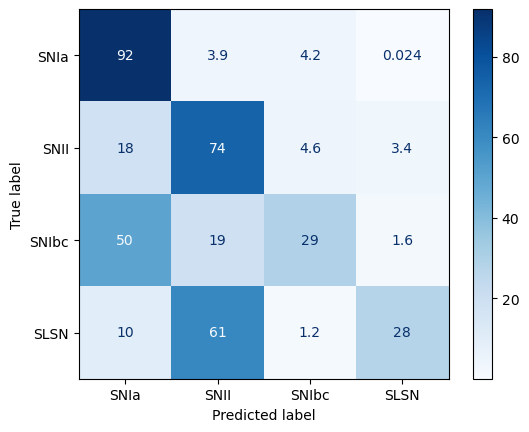

Model: Transient_Depth=3
Precision: Mean = 0.5827552790582636; Std = 0.025870015648705478
Recall: Mean = 0.5477825780849973; Std = 0.030772346379967147
F1-score: Mean = 0.5596997175603805; Std = 0.028806311894572497
Min recall: Mean = 0.21451612903225808; Std = 0.075561546745114
Mod recall: Mean = 0.3114903707328283; Std = 0.07559073696067317


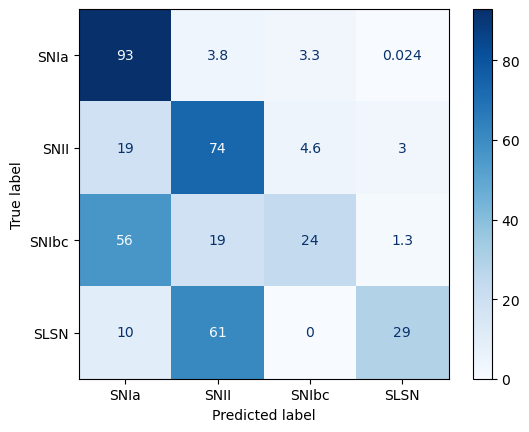

Model: Transient_Depth=4
Precision: Mean = 0.5920526493250956; Std = 0.03122055881297858
Recall: Mean = 0.5563878221539513; Std = 0.036158707781352946
F1-score: Mean = 0.5687872912368368; Std = 0.03403283253484937
Min recall: Mean = 0.21693548387096775; Std = 0.0675881510959902
Mod recall: Mean = 0.32421007501676785; Std = 0.09577992144116625


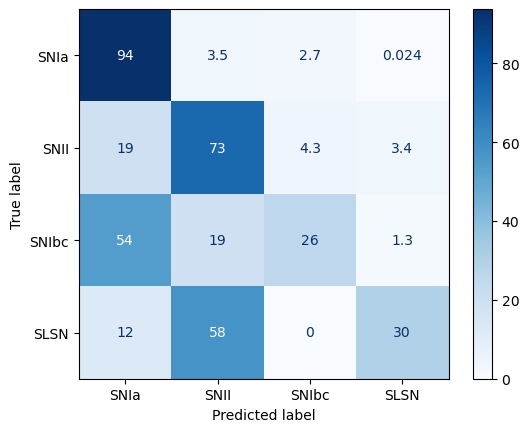

Model: Transient_Depth=5
Precision: Mean = 0.588864267991285; Std = 0.018313330347925056
Recall: Mean = 0.5553590629800308; Std = 0.027554599185067995
F1-score: Mean = 0.5661889611933315; Std = 0.02307272765850077
Min recall: Mean = 0.21733870967741936; Std = 0.06052283691071598
Mod recall: Mean = 0.3382517809534678; Std = 0.07687756814937524


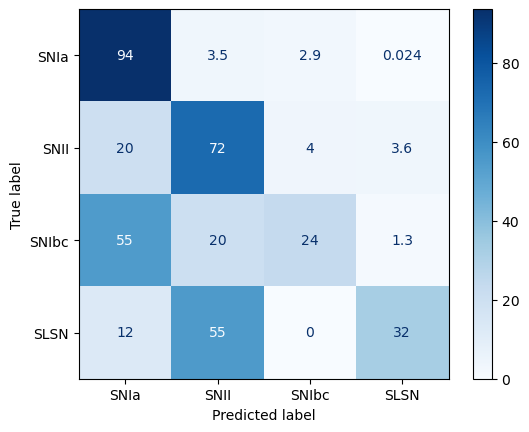

Model: Transient_Depth=6
Precision: Mean = 0.5793769161185496; Std = 0.04563851009887491
Recall: Mean = 0.5367509387267452; Std = 0.037756592828005885
F1-score: Mean = 0.549976664379682; Std = 0.038370893781823345
Min recall: Mean = 0.17983870967741938; Std = 0.0873093284509012
Mod recall: Mean = 0.2967278190946227; Std = 0.10172614108101155


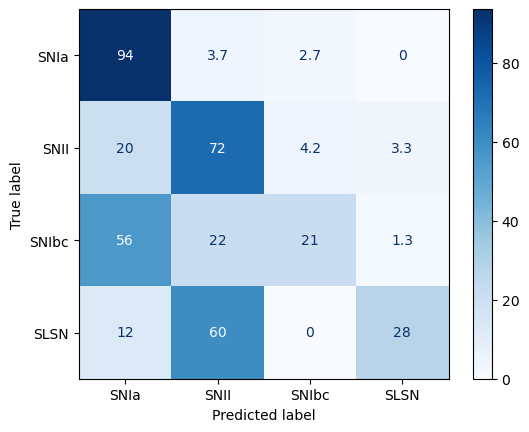

Model: Transient_Depth=7
Precision: Mean = 0.5977479377283489; Std = 0.03344427802086687
Recall: Mean = 0.5538556067588327; Std = 0.037747421228981906
F1-score: Mean = 0.5680769571138657; Std = 0.034179073998412475
Min recall: Mean = 0.20766129032258066; Std = 0.09220126409619624
Mod recall: Mean = 0.3227553320429731; Std = 0.09471261790476265


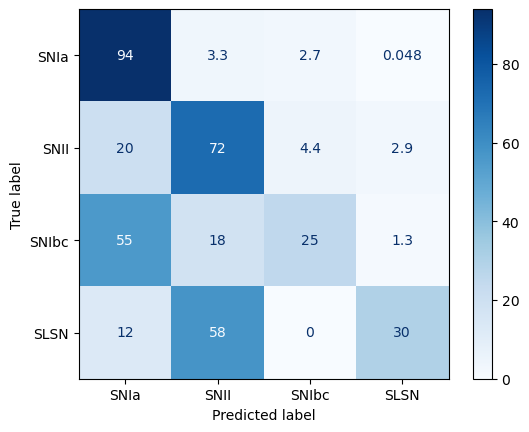

Model: Transient_Depth=8
Precision: Mean = 0.5965720893630054; Std = 0.03359473584279955
Recall: Mean = 0.5500792584058714; Std = 0.02980737537928752
F1-score: Mean = 0.5659698189786797; Std = 0.029175327486067784
Min recall: Mean = 0.21975806451612906; Std = 0.0577964803648097
Mod recall: Mean = 0.32700096351469166; Std = 0.07687791874218439


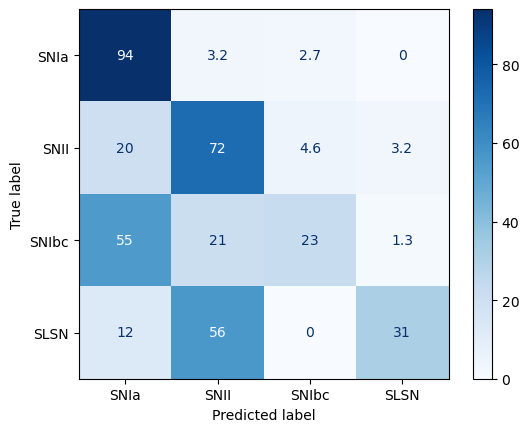

Model: Transient_Depth=9
Precision: Mean = 0.576695045434214; Std = 0.04224735643247307
Recall: Mean = 0.5393075823519372; Std = 0.030709568800981534
F1-score: Mean = 0.5507173671896355; Std = 0.030809012622676407
Min recall: Mean = 0.1657258064516129; Std = 0.06384352008804065
Mod recall: Mean = 0.30542261743092136; Std = 0.08933346695067888


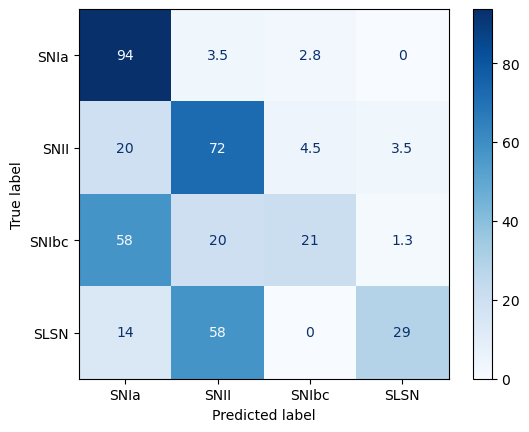

Model: Transient_Depth=10
Precision: Mean = 0.5812731289764962; Std = 0.029993183376525626
Recall: Mean = 0.5399837856289469; Std = 0.027216152599097595
F1-score: Mean = 0.5542372755880123; Std = 0.027248211111081905
Min recall: Mean = 0.1814516129032258; Std = 0.05656670295725865
Mod recall: Mean = 0.29871129727269846; Std = 0.08695400069481568


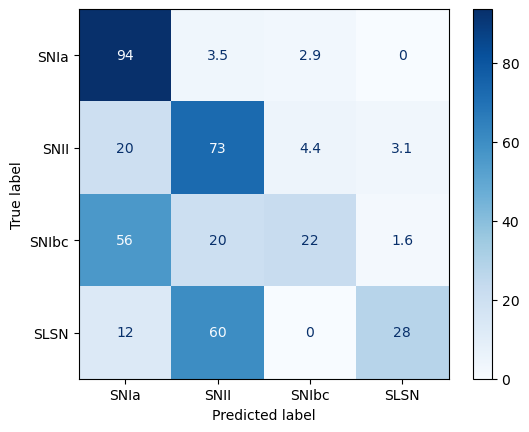

In [48]:
subclass= 'Transient'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)


n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=[]
recalls=[]
f1s=[]
matrixes=[]
minrecalls=[]
modrecalls=[]
preds_dict=[]
tests_dict=[]
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
    dtrain = xgb.DMatrix(data=X_train, label=y_train
                         ,weight=pd.Series(y_train).map(lambda x: class_weights[x])
                        )
    dvalid = xgb.DMatrix(data=X_test, label=y_test)

    
    precisions_temp=[]
    recalls_temp=[]
    f1s_temp=[]
    matrixes_temp=[]
    minrecalls_temp=[]
    modrecalls_temp=[]
    preds_dict_temp=[]
    tests_dict_temp=[]
    params = {'colsample_bytree': 0.9, 'eta': 0.1, 'gamma': 1.3, 'min_child_weight': 4.0, 'subsample': 0.6000000000000001, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'booster': 'gbtree', 'tree_method': 'gpu_hist', 'num_class': 4}
    for j in range(10):
        print('depth ' + str(j+1))
        params['max_depth'] = j+1
        watchlist = [(dtrain, 'train')]
        gbm_model = xgb.train(params, dtrain, 1500,
                                  evals=watchlist,
                                  verbose_eval=False,
                                  custom_metric=min_recall,
                                  early_stopping_rounds=15)
        preds = gbm_model.predict(dvalid,
                                            iteration_range=(1,gbm_model.best_iteration + 1))
        for k in range(len(preds)):
            preds[k] = np.exp(preds[k])/np.sum(np.exp(preds[k]))
        preds_test = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)

        precisions_temp.append(precision_score(y_test,preds_test,average='macro'))
        recalls_temp.append(recall_score(y_test,preds_test,average='macro'))
        f1s_temp.append(f1_score(y_test,preds_test,average='macro'))
        matrixes_temp.append(confusion_matrix(y_test,preds_test,normalize='true')*100)
        minrecalls_temp.append(np.min(recall_score(y_test, preds_test, average=None)))
        modrecalls_temp.append(recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True))))
        
        preds_dict_temp.append(preds)
        tests_dict_temp.append(y_test)
    precisions.append(precisions_temp)
    recalls.append(recalls_temp)
    f1s.append(f1s_temp)
    matrixes.append(matrixes_temp)
    minrecalls.append(minrecalls_temp)
    modrecalls.append(modrecalls_temp)    
    preds_dict.append(preds_dict_temp)
    tests_dict.append(tests_dict_temp)
    i=i+1
file_name = 'ResultadosFinales/Transient_Recall_MaxDepthVar_Preds_depth_v2.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Transient_Recall_MaxDepthVar_Tests_depth_v2.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)

for k in range(10):
    
    print('Model: Transient_Depth='+str(k+1))
    print('Precision: Mean = ' + str(np.mean(precisions,axis=0)[k]) + '; Std = '+ str(np.std(precisions,axis=0)[k]))
    print('Recall: Mean = ' + str(np.mean(recalls,axis=0)[k]) + '; Std = '+ str(np.std(recalls,axis=0)[k]))
    print('F1-score: Mean = ' + str(np.mean(f1s,axis=0)[k]) + '; Std = '+ str(np.std(f1s,axis=0)[k]))
    print('Min recall: Mean = ' + str(np.mean(minrecalls,axis=0)[k]) + '; Std = '+ str(np.std(minrecalls,axis=0)[k]))
    print('Mod recall: Mean = ' + str(np.mean(modrecalls,axis=0)[k]) + '; Std = '+ str(np.std(modrecalls,axis=0)[k]))


    disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0)[k], display_labels=Labels_dict[subclass])
    disp.plot(cmap='Blues')
    plt.show()

# Transient Max_depth variable, objective metric= recall


iteration 0
Optimizing parameters
 37%|████████████████▉                             | 221/600 [05:39<09:41,  1.53s/trial, best loss: 0.3291493431575331]
The best hyperparameters are:  

{'colsample_bytree': 0.8500000000000001, 'eta': 0.375, 'gamma': 1.4000000000000001, 'max_depth': 9, 'mds': 1.0, 'min_child_weight': 4.0, 'subsample': 0.65, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'booster': 'gbtree', 'tree_method': 'gpu_hist', 'num_class': 4}
[22:09:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "mds" } are not used.

iteration 1
Optimizing parameters
 38%|█████████████████▏                           | 229/600 [05:00<08:06,  1.31s/trial, best loss: 0.28614722835460904]
The best hyperparameters are:  

{'colsample_bytree': 1.0, 'eta': 0.42500000000000004, 'gamma': 0.7000000000000001, 'max_depth': 6, 'mds': 7.0, 'min_child_weight': 2.0, 'subsample': 0.9, '

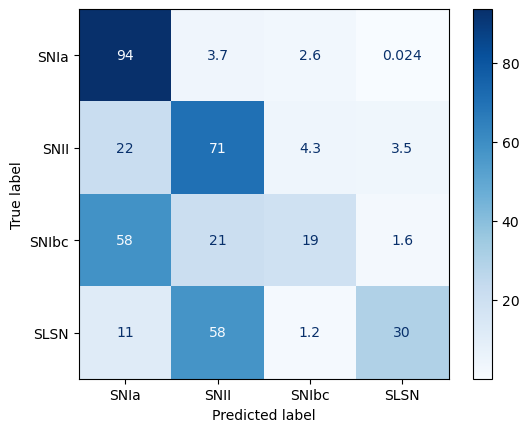

In [10]:

subclass= 'Transient'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)


n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=np.zeros(n_splits)
recalls=np.zeros(n_splits)
f1s=np.zeros(n_splits)
matrixes=np.zeros((n_splits,n_classes,n_classes))
minrecalls=np.zeros(n_splits)
modrecalls=np.zeros(n_splits)
preds_dict={}
tests_dict={}
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
    dtrain = xgb.DMatrix(data=X_train, label=y_train
                         ,weight=pd.Series(y_train).map(lambda x: class_weights[x])
                        )
    dvalid = xgb.DMatrix(data=X_test, label=y_test)

    
    def score(params):
        
        #print(params)
        num_round = 500
        X_train_nest,X_valid_nest, y_train_nest, y_valid_nest = train_test_split(X_train, 
                                                                                 y_train, 
                                                                                 test_size=0.33,
                                                                                 stratify=y_train)
        class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
        dtrainnested = xgb.DMatrix(data=X_train_nest, label=y_train_nest
                                  ,weight=pd.Series(y_train_nest).map(lambda x: class_weights[x]))
        dvalidnested = xgb.DMatrix(data=X_valid_nest, label=y_valid_nest)
        watchlist = [(dtrainnested, 'train')]
        params['max_depth']= int(params['max_depth'])
        gbm_model = xgb.train(params, dtrainnested, num_round,
                              evals=watchlist,
                              verbose_eval=False,
                              early_stopping_rounds=15)
        preds = gbm_model.predict(dvalidnested,
                                        iteration_range=(1,gbm_model.best_iteration + 1))
        for j in range(len(preds)):
            preds[j] = np.exp(preds[j])/np.sum(np.exp(preds[j]))
        y_pred = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)
        y_true = np.array(dvalidnested.get_label(), dtype=int, ndmin=1)
        
        score = recall_score(y_true, y_pred,average='macro')
        loss = 1 - score
        return {'loss': loss, 'status': STATUS_OK}

    def optimize(
                 trials, 
                 #random_state=SEED
                ):
        space = {
            'eta': hp.quniform('eta', 0.025, 1, 0.025),
            'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'gamma': hp.quniform('gamma', 0, 1.5, 0.1),
            'max_depth': hp.quniform('max_depth', 1, 12, 3),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
            'max_delta_step': hp.quniform('mds', 0, 10, 1),
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'booster': 'gbtree',
            'tree_method': 'gpu_hist',
            'num_class': n_classes,
            #scale_pos_weight sum(negative instances) / sum(positive instances)
        }
        best = fmin(score, space, algo=tpe.suggest, 
                    trials=trials, 
                    max_evals=600,early_stop_fn=no_progress_loss(200))
        return best
    
    print('Optimizing parameters')
    best_params = optimize(
                            Trials()
                            )
    best_params['eval_metric']= 'mlogloss'
    best_params['objective']= 'multi:softprob'
    best_params['booster']= 'gbtree'
    best_params['tree_method']= 'gpu_hist'
    best_params['num_class']= n_classes
    best_params['max_depth']= int(best_params['max_depth'])
    print("The best hyperparameters are: ", "\n")
    print(best_params)
    watchlist = [(dtrain, 'train')]
    gbm_model = xgb.train(best_params, dtrain, 500,
                              evals=watchlist,
                              verbose_eval=False,
                              early_stopping_rounds=15)
    preds = gbm_model.predict(dvalid,
                                        iteration_range=(1,gbm_model.best_iteration + 1))
    for k in range(len(preds)):
        preds[k] = np.exp(preds[k])/np.sum(np.exp(preds[k]))
    preds_test = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)
    
    classreport=classification_report(y_test,preds_test,output_dict=True)
    precisions[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['precision']
    recalls[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['recall']
    f1s[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['f1-score']
    matrixes[i]=confusion_matrix(y_test,preds_test,normalize='true')*100
    minrecalls[i]=np.min(recall_score(y_test, preds_test, average=None))
    modrecalls[i]=recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True)))
    
    i=i+1
    preds_dict[i]=preds
    tests_dict[i]=y_test
file_name = 'ResultadosFinales/Transient_Recall_MaxDepthVar_Preds_depth.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Transient_Recall_MaxDepthVar_Tests_depth.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)
    
print('Model: Transient_Recall_MaxDepthVar')
print('Precision: Mean = ' + str(np.mean(precisions)) + '; Std = '+ str(np.std(precisions)))
print('Recall: Mean = ' + str(np.mean(recalls)) + '; Std = '+ str(np.std(recalls)))
print('F1-score: Mean = ' + str(np.mean(f1s)) + '; Std = '+ str(np.std(f1s)))
print('Min recall: Mean = ' + str(np.mean(minrecalls)) + '; Std = '+ str(np.std(minrecalls)))
print('Weighted recall: Mean = ' + str(np.mean(modrecalls)) + '; Std = '+ str(np.std(modrecalls)))

disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0), display_labels=Labels_dict[subclass])
disp.plot(cmap='Blues')
plt.show()

# Transient Max_depth variable, objective metric= mod_recall


iteration 0
Optimizing parameters
100%|██████████████████████████████████████████████| 600/600 [16:37<00:00,  1.66s/trial, best loss: 0.2972979733581361]
The best hyperparameters are:  

{'colsample_bytree': 1.0, 'eta': 0.30000000000000004, 'gamma': 0.9, 'max_depth': 0, 'mds': 6.0, 'min_child_weight': 7.0, 'subsample': 0.65, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'booster': 'gbtree', 'tree_method': 'gpu_hist', 'num_class': 4}
[16:15:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "mds" } are not used.

iteration 1
Optimizing parameters
 61%|███████████████████████████▍                 | 366/600 [08:04<05:09,  1.32s/trial, best loss: 0.16569028425836474]
The best hyperparameters are:  

{'colsample_bytree': 1.0, 'eta': 0.325, 'gamma': 1.3, 'max_depth': 0, 'mds': 10.0, 'min_child_weight': 5.0, 'subsample': 0.9, 'eval_metric': 'mlogloss', 'objective': 'mult

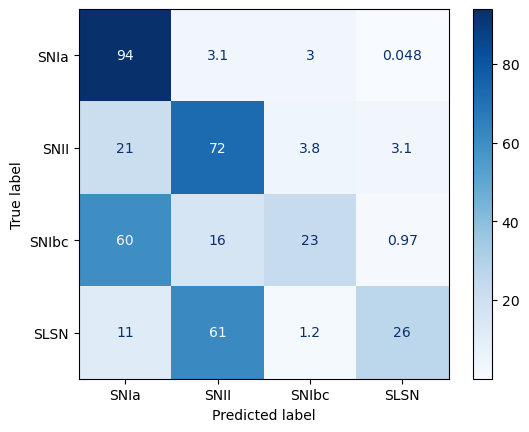

In [9]:
subclass= 'Transient'

X_sc = X.loc[y_h==subclass, :]
y_sc = y_o.loc[y_h==subclass]
y_sc_enc=LabelEncoder(y_sc)


n_splits=10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=42)
i=0
n_classes=len(y_sc.unique())
precisions=np.zeros(n_splits)
recalls=np.zeros(n_splits)
f1s=np.zeros(n_splits)
matrixes=np.zeros((n_splits,n_classes,n_classes))
minrecalls=np.zeros(n_splits)
modrecalls=np.zeros(n_splits)
preds_dict={}
tests_dict={}
for train_index, test_index in sss.split(X_sc, y_sc_enc):
    print('iteration '+str(i))
    X_train, X_test = X_sc.iloc[train_index], X_sc.iloc[test_index]
    y_train, y_test = y_sc_enc.iloc[train_index], y_sc_enc.iloc[test_index]
    class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
    dtrain = xgb.DMatrix(data=X_train, label=y_train
                         ,weight=pd.Series(y_train).map(lambda x: class_weights[x])
                        )
    dvalid = xgb.DMatrix(data=X_test, label=y_test)

    
    def score(params):
        
        #print(params)
        num_round = 500
        X_train_nest,X_valid_nest, y_train_nest, y_valid_nest = train_test_split(X_train, 
                                                                                 y_train, 
                                                                                 test_size=0.33,
                                                                                 stratify=y_train)
        class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
        dtrainnested = xgb.DMatrix(data=X_train_nest, label=y_train_nest
                                  ,weight=pd.Series(y_train_nest).map(lambda x: class_weights[x]))
        dvalidnested = xgb.DMatrix(data=X_valid_nest, label=y_valid_nest)
        watchlist = [(dtrainnested, 'train')]
        params['max_depth']= int(params['max_depth'])
        gbm_model = xgb.train(params, dtrainnested, num_round,
                              evals=watchlist,
                              verbose_eval=False,
                              early_stopping_rounds=15)
        preds = gbm_model.predict(dvalidnested,
                                        iteration_range=(1,gbm_model.best_iteration + 1))
        for j in range(len(preds)):
            preds[j] = np.exp(preds[j])/np.sum(np.exp(preds[j]))
        y_pred = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)
        y_true = np.array(dvalidnested.get_label(), dtype=int, ndmin=1)
        
        score = recall_mod_v1(y_true, y_pred,1/np.array(y_train.value_counts(normalize=True)))
        loss = 1 - score
        return {'loss': loss, 'status': STATUS_OK}

    def optimize(
                 trials, 
                 #random_state=SEED
                ):
        space = {
            'eta': hp.quniform('eta', 0.025, 1, 0.025),
            'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'gamma': hp.quniform('gamma', 0, 1.5, 0.1),
            'max_depth': hp.quniform('max_depth', 1, 12, 3),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
            'max_delta_step': hp.quniform('mds', 0, 10, 1),
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'booster': 'gbtree',
            'tree_method': 'gpu_hist',
            'num_class': n_classes,
            #scale_pos_weight sum(negative instances) / sum(positive instances)
        }
        best = fmin(score, space, algo=tpe.suggest, 
                    trials=trials, 
                    max_evals=600,early_stop_fn=no_progress_loss(200))
        return best
    
    print('Optimizing parameters')
    best_params = optimize(
                            Trials()
                            )
    best_params['eval_metric']= 'mlogloss'
    best_params['objective']= 'multi:softprob'
    best_params['booster']= 'gbtree'
    best_params['tree_method']= 'gpu_hist'
    best_params['num_class']= n_classes
    best_params['max_depth']= int(best_params['max_depth'])
    print("The best hyperparameters are: ", "\n")
    print(best_params)
    watchlist = [(dtrain, 'train')]
    gbm_model = xgb.train(best_params, dtrain, 500,
                              evals=watchlist,
                              verbose_eval=False,
                              early_stopping_rounds=15)
    preds = gbm_model.predict(dvalid,
                                        iteration_range=(1,gbm_model.best_iteration + 1))
    for k in range(len(preds)):
        preds[k] = np.exp(preds[k])/np.sum(np.exp(preds[k]))
    preds_test = np.array(np.argmax(np.array(preds),axis=1), ndmin=1)
    
    classreport=classification_report(y_test,preds_test,output_dict=True)
    precisions[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['precision']
    recalls[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['recall']
    f1s[i]=classification_report(y_test,preds_test,output_dict=True)['macro avg']['f1-score']
    matrixes[i]=confusion_matrix(y_test,preds_test,normalize='true')*100
    minrecalls[i]=np.min(recall_score(y_test, preds_test, average=None))
    modrecalls[i]=recall_mod_v1(y_test,preds_test,1/np.array(y_train.value_counts(normalize=True)))
    
    i=i+1
    preds_dict[i]=preds
    tests_dict[i]=y_test
file_name = 'ResultadosFinales/Transient_ModRecall_MaxDepthVar_Preds_depth.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(preds_dict, pickle_file)
file_name = 'ResultadosFinales/Transient_ModRecall_MaxDepthVar_Tests_depth.pkl'
with open(file_name, 'wb') as pickle_file:
    pickle.dump(tests_dict, pickle_file)
    
print('Model: Transient_ModRecall_MaxDepthVar')
print('Precision: Mean = ' + str(np.mean(precisions)) + '; Std = '+ str(np.std(precisions)))
print('Recall: Mean = ' + str(np.mean(recalls)) + '; Std = '+ str(np.std(recalls)))
print('F1-score: Mean = ' + str(np.mean(f1s)) + '; Std = '+ str(np.std(f1s)))
print('Min recall: Mean = ' + str(np.mean(minrecalls)) + '; Std = '+ str(np.std(minrecalls)))
print('Weighted recall: Mean = ' + str(np.mean(modrecalls)) + '; Std = '+ str(np.std(modrecalls)))

disp=ConfusionMatrixDisplay(np.mean(matrixes,axis=0), display_labels=Labels_dict[subclass])
disp.plot(cmap='Blues')
plt.show()